In [1]:
from preprocessing_last20 import *
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
from d2c_encoder import D2CEncoder
from d2c_decoder import D2CDecoder
device = torch.device('cuda:0')
train_data = train_data.to(device)
test_data = test_data.to(device)

In [2]:
ddpm = DDPM(eps_model=NaiveUnet(16, 16, n_feat=128), betas=(1e-4, 0.02), n_T=200).to(device)
encoder = D2CEncoder().to(device)
decoder = D2CDecoder().to(device)
MSE = nn.MSELoss()

In [3]:
def train_1_ep_d2c(num_epoch, optim_e, optim_g, optim_d, alpha):

    print(f"Epoch {num_epoch} : ")
    ddpm.train()
    encoder.train()
    decoder.train()
    
    # batch of size 4
    train_data_tmp = train_data[torch.randperm(train_data.size()[0])]
    train_data_tmp = train_data_tmp.reshape(50, 4, 1, 64, 64)
    
    for i in tqdm(range(train_data_tmp.shape[0])):
        optim_e.zero_grad()
        optim_g.zero_grad()
        optim_d.zero_grad()
        z = encoder(train_data_tmp[i])
        l_d, denoised_z = ddpm.forward(z, True)
        l_e = MSE(z, denoised_z)
        l_g = MSE(train_data_tmp[i], decoder(denoised_z))
        loss = l_d+l_e+l_g*alpha
        loss.backward()

        optim_e.step()
        optim_g.step()
        optim_d.step()
    print('loss: ',loss.item(), " l_d: ", l_d.item(), " l_e: ", l_e.item(), " l_g: ", l_g.item())
    if num_epoch%20 == 0:
        ddpm.eval()
        with torch.no_grad():
            xh = decoder(ddpm.sample(1, (16, 32, 32), device))
            tensor_to_picture(xh.detach().cpu().numpy()[0][0])

    # save model
    torch.save(ddpm.state_dict(), f"./d2c_ddpm.pth")
    torch.save(encoder.state_dict(), f"./d2c_encoder.pth")
    torch.save(decoder.state_dict(), f"./d2c_decoder.pth")

In [9]:
def test_d2c(encoder, decoder, diffusion, i):  
#     gan_input = torch.normal(0, 1, size=(1,1,64, 64)) # noise
    encoder.eval()
    decoder.eval()
    diffusion.eval()
    tensor_to_picture(decoder(encoder(test_data[i])).detach().cpu().numpy()[0][0])

In [4]:
def train_d2c(epoch, lr, lr_decay, reg, alpha):
    for i in range(epoch):
        
        optim_e = torch.optim.SGD(encoder.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        optim_g = torch.optim.SGD(decoder.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        optim_d = torch.optim.SGD(ddpm.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        train_1_ep_d2c(i, optim_e, optim_g, optim_d, alpha)

Epoch 0 : 


100%|██████████| 50/50 [00:04<00:00, 11.76it/s]


loss:  3.2023863792419434  l_d:  0.8072885870933533  l_e:  0.8072885870933533  l_g:  0.7939045429229736


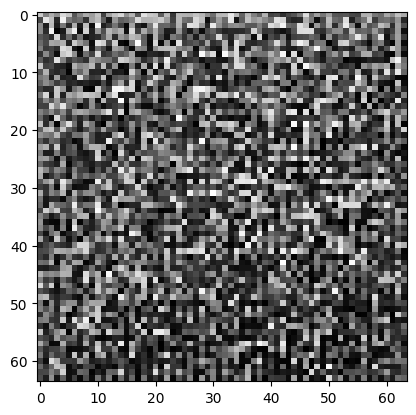

Epoch 1 : 


100%|██████████| 50/50 [00:04<00:00, 12.49it/s]


loss:  3.621321439743042  l_d:  0.6408308744430542  l_e:  0.6408308744430542  l_g:  1.1698298454284668
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


loss:  2.379467487335205  l_d:  0.5445421934127808  l_e:  0.5445421934127808  l_g:  0.6451915502548218
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


loss:  2.284856081008911  l_d:  0.4586307108402252  l_e:  0.4586307108402252  l_g:  0.683797299861908
Epoch 4 : 


100%|██████████| 50/50 [00:04<00:00, 11.87it/s]


loss:  1.5484695434570312  l_d:  0.3885348439216614  l_e:  0.3885347843170166  l_g:  0.38569992780685425
Epoch 5 : 


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


loss:  1.5040206909179688  l_d:  0.36808061599731445  l_e:  0.36808061599731445  l_g:  0.3839297294616699
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


loss:  1.2017130851745605  l_d:  0.3380719721317291  l_e:  0.3380719721317291  l_g:  0.26278460025787354
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


loss:  1.1086008548736572  l_d:  0.24212904274463654  l_e:  0.24212904274463654  l_g:  0.31217139959335327
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 16.07it/s]


loss:  1.2038923501968384  l_d:  0.29326295852661133  l_e:  0.29326295852661133  l_g:  0.30868321657180786
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


loss:  1.003037452697754  l_d:  0.218694806098938  l_e:  0.218694806098938  l_g:  0.28282395005226135
Epoch 10 : 


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


loss:  0.8785495758056641  l_d:  0.1942042112350464  l_e:  0.1942042112350464  l_g:  0.24507057666778564
Epoch 11 : 


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


loss:  1.0222444534301758  l_d:  0.1863653063774109  l_e:  0.1863653063774109  l_g:  0.324756920337677
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 14.67it/s]


loss:  0.9641649723052979  l_d:  0.22986532747745514  l_e:  0.22986531257629395  l_g:  0.252217173576355
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 14.86it/s]


loss:  0.7451335191726685  l_d:  0.17543229460716248  l_e:  0.17543229460716248  l_g:  0.19713446497917175
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  0.8397989273071289  l_d:  0.18871575593948364  l_e:  0.18871575593948364  l_g:  0.2311837077140808
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


loss:  0.8207336664199829  l_d:  0.1548762172460556  l_e:  0.1548762172460556  l_g:  0.25549060106277466
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 14.76it/s]


loss:  0.8775299191474915  l_d:  0.17081138491630554  l_e:  0.17081138491630554  l_g:  0.2679535746574402
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  0.6770116090774536  l_d:  0.13682004809379578  l_e:  0.13682004809379578  l_g:  0.20168575644493103
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 16.11it/s]


loss:  0.7150959968566895  l_d:  0.1693669706583023  l_e:  0.1693669706583023  l_g:  0.18818101286888123
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  0.6535770893096924  l_d:  0.13859102129936218  l_e:  0.13859102129936218  l_g:  0.188197523355484
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


loss:  0.8437310457229614  l_d:  0.12909254431724548  l_e:  0.12909254431724548  l_g:  0.29277297854423523


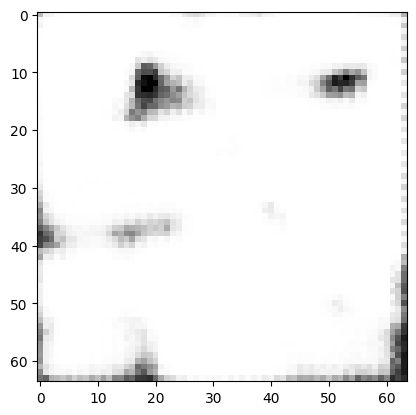

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


loss:  1.0433796644210815  l_d:  0.26994937658309937  l_e:  0.26994937658309937  l_g:  0.2517404556274414
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  0.6585806608200073  l_d:  0.12144188582897186  l_e:  0.12144188582897186  l_g:  0.2078484445810318
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


loss:  0.8086774349212646  l_d:  0.17655518651008606  l_e:  0.17655518651008606  l_g:  0.22778353095054626
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


loss:  0.6586500406265259  l_d:  0.11754114925861359  l_e:  0.11754114925861359  l_g:  0.21178387105464935
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 15.62it/s]


loss:  0.7300561666488647  l_d:  0.11261643469333649  l_e:  0.11261643469333649  l_g:  0.2524116635322571
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


loss:  0.7257639169692993  l_d:  0.18574267625808716  l_e:  0.18574267625808716  l_g:  0.1771392822265625
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


loss:  0.567441463470459  l_d:  0.11090622842311859  l_e:  0.11090622842311859  l_g:  0.1728144884109497
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


loss:  0.7155239582061768  l_d:  0.10857556760311127  l_e:  0.10857556760311127  l_g:  0.2491864264011383
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


loss:  0.6577538847923279  l_d:  0.1284809708595276  l_e:  0.1284809708595276  l_g:  0.20039597153663635
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


loss:  0.7306768894195557  l_d:  0.10603772103786469  l_e:  0.10603772103786469  l_g:  0.25930073857307434
Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


loss:  0.7502115964889526  l_d:  0.11836148053407669  l_e:  0.11836148053407669  l_g:  0.2567443251609802
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  0.5511940121650696  l_d:  0.1050001010298729  l_e:  0.1050001010298729  l_g:  0.1705968976020813
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


loss:  0.7470647096633911  l_d:  0.12721918523311615  l_e:  0.12721920013427734  l_g:  0.24631313979625702
Epoch 34 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  0.5069077014923096  l_d:  0.09936781227588654  l_e:  0.09936781227588654  l_g:  0.15408605337142944
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  0.6799191832542419  l_d:  0.10073058307170868  l_e:  0.10073058307170868  l_g:  0.2392290085554123
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  0.5847619771957397  l_d:  0.13157811760902405  l_e:  0.13157811760902405  l_g:  0.16080287098884583
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 14.57it/s]


loss:  0.7770857214927673  l_d:  0.13117915391921997  l_e:  0.13117913901805878  l_g:  0.2573637068271637
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


loss:  0.5942546129226685  l_d:  0.09646899998188019  l_e:  0.09646899998188019  l_g:  0.20065830647945404
Epoch 39 : 


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


loss:  0.5789998769760132  l_d:  0.09512223303318024  l_e:  0.09512223303318024  l_g:  0.19437769055366516
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 14.86it/s]


loss:  0.7406220436096191  l_d:  0.09612397849559784  l_e:  0.09612397849559784  l_g:  0.27418702840805054


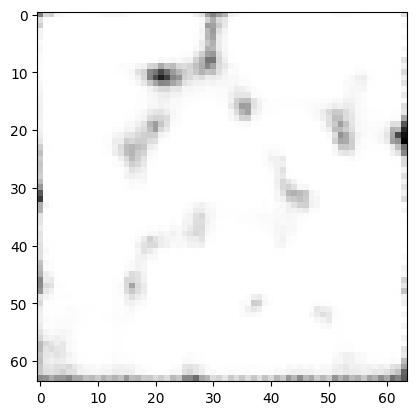

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


loss:  0.664271354675293  l_d:  0.0959593653678894  l_e:  0.0959593653678894  l_g:  0.2361762970685959
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


loss:  0.47868800163269043  l_d:  0.09956749528646469  l_e:  0.09956749528646469  l_g:  0.13977649807929993
Epoch 43 : 


100%|██████████| 50/50 [00:04<00:00, 12.19it/s]


loss:  0.7504111528396606  l_d:  0.12649375200271606  l_e:  0.12649375200271606  l_g:  0.24871182441711426
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


loss:  0.5900865793228149  l_d:  0.09636946022510529  l_e:  0.09636946022510529  l_g:  0.198673814535141
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


loss:  0.5188038349151611  l_d:  0.09863394498825073  l_e:  0.09863394498825073  l_g:  0.16076795756816864
Epoch 46 : 


100%|██████████| 50/50 [00:04<00:00, 12.41it/s]


loss:  0.5133647918701172  l_d:  0.09555549919605255  l_e:  0.09555549919605255  l_g:  0.16112691164016724
Epoch 47 : 


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


loss:  0.6357616186141968  l_d:  0.12499062716960907  l_e:  0.12499062716960907  l_g:  0.19289018213748932
Epoch 48 : 


100%|██████████| 50/50 [00:04<00:00, 10.78it/s]


loss:  0.525615930557251  l_d:  0.09544800966978073  l_e:  0.09544800221920013  l_g:  0.16735997796058655
Epoch 49 : 


100%|██████████| 50/50 [00:04<00:00, 11.80it/s]


loss:  0.6363524198532104  l_d:  0.095216304063797  l_e:  0.095216304063797  l_g:  0.22295989096164703
Epoch 50 : 


100%|██████████| 50/50 [00:04<00:00, 11.48it/s]


loss:  0.5761340856552124  l_d:  0.09869806468486786  l_e:  0.09869806468486786  l_g:  0.18936899304389954
Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


loss:  0.8064799308776855  l_d:  0.10840761661529541  l_e:  0.10840761661529541  l_g:  0.29483234882354736
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  0.5657743215560913  l_d:  0.09261924028396606  l_e:  0.09261924028396606  l_g:  0.1902679204940796
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


loss:  0.6023231148719788  l_d:  0.08950931578874588  l_e:  0.08950931578874588  l_g:  0.2116522490978241
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 16.07it/s]


loss:  0.6398760080337524  l_d:  0.09117525815963745  l_e:  0.09117525815963745  l_g:  0.22876276075839996
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 14.79it/s]


loss:  0.640072762966156  l_d:  0.0917770266532898  l_e:  0.0917770266532898  l_g:  0.2282593548297882
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


loss:  0.8191134929656982  l_d:  0.18164491653442383  l_e:  0.18164491653442383  l_g:  0.2279118448495865
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


loss:  0.5272947549819946  l_d:  0.09055814146995544  l_e:  0.09055814892053604  l_g:  0.17308923602104187
Epoch 58 : 


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


loss:  0.4694797992706299  l_d:  0.0888962596654892  l_e:  0.0888962671160698  l_g:  0.14584363996982574
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 14.39it/s]


loss:  0.5574073195457458  l_d:  0.08824676275253296  l_e:  0.08824676275253296  l_g:  0.19045689702033997
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


loss:  0.649312436580658  l_d:  0.09131566435098648  l_e:  0.09131566435098648  l_g:  0.2333405464887619


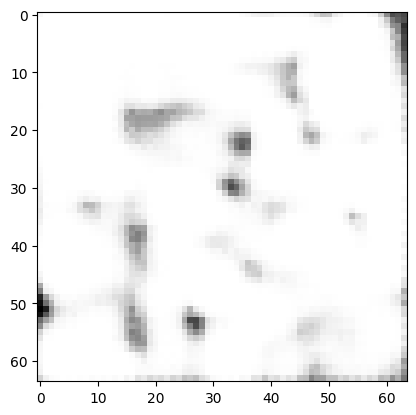

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 12.95it/s]


loss:  0.8955922722816467  l_d:  0.1878758668899536  l_e:  0.1878758668899536  l_g:  0.25992026925086975
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


loss:  1.0376826524734497  l_d:  0.24725091457366943  l_e:  0.24725091457366943  l_g:  0.2715904116630554
Epoch 63 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  0.9184732437133789  l_d:  0.146141916513443  l_e:  0.146141916513443  l_g:  0.31309470534324646
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


loss:  0.7536819577217102  l_d:  0.1557297557592392  l_e:  0.1557297557592392  l_g:  0.2211112231016159
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


loss:  0.6307969689369202  l_d:  0.08705160021781921  l_e:  0.08705160021781921  l_g:  0.22834688425064087
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


loss:  0.6251787543296814  l_d:  0.09465639293193817  l_e:  0.09465639293193817  l_g:  0.21793298423290253
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 13.35it/s]


loss:  0.6108847856521606  l_d:  0.08911868929862976  l_e:  0.08911868929862976  l_g:  0.21632368862628937
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


loss:  0.828645646572113  l_d:  0.19020485877990723  l_e:  0.19020487368106842  l_g:  0.2241179645061493
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


loss:  0.5918217897415161  l_d:  0.10484917461872101  l_e:  0.10484917461872101  l_g:  0.19106170535087585
Epoch 70 : 


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


loss:  0.9241625070571899  l_d:  0.2643405795097351  l_e:  0.2643405795097351  l_g:  0.19774067401885986
Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


loss:  0.48765984177589417  l_d:  0.08801625669002533  l_e:  0.08801625669002533  l_g:  0.15581366419792175
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


loss:  0.45878347754478455  l_d:  0.08691827952861786  l_e:  0.08691827952861786  l_g:  0.14247345924377441
Epoch 73 : 


100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


loss:  0.7646808624267578  l_d:  0.0912337452173233  l_e:  0.0912337452173233  l_g:  0.2911067008972168
Epoch 74 : 


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


loss:  0.6633511781692505  l_d:  0.15004241466522217  l_e:  0.15004241466522217  l_g:  0.18163317441940308
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


loss:  0.6183444857597351  l_d:  0.08958128094673157  l_e:  0.08958128094673157  l_g:  0.219590961933136
Epoch 76 : 


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


loss:  0.7584532499313354  l_d:  0.09425420314073563  l_e:  0.09425420314073563  l_g:  0.2849724292755127
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


loss:  0.7204288840293884  l_d:  0.08475717902183533  l_e:  0.08475717157125473  l_g:  0.2754572629928589
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 12.58it/s]


loss:  0.5762097835540771  l_d:  0.09329909086227417  l_e:  0.09329909086227417  l_g:  0.1948058158159256
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  0.5124783515930176  l_d:  0.0897352546453476  l_e:  0.0897352546453476  l_g:  0.1665039360523224
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


loss:  0.45775678753852844  l_d:  0.08706557750701904  l_e:  0.08706557750701904  l_g:  0.14181281626224518


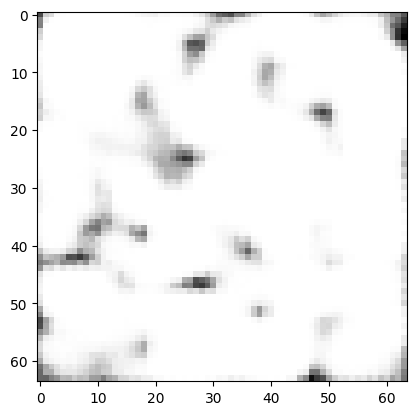

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


loss:  0.772168755531311  l_d:  0.19352902472019196  l_e:  0.19352903962135315  l_g:  0.19255533814430237
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 14.30it/s]


loss:  1.0303611755371094  l_d:  0.31012991070747375  l_e:  0.31012991070747375  l_g:  0.20505066215991974
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 12.68it/s]


loss:  0.42749136686325073  l_d:  0.0880415290594101  l_e:  0.0880415290594101  l_g:  0.12570415437221527
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


loss:  0.5422861576080322  l_d:  0.08921940624713898  l_e:  0.08921940624713898  l_g:  0.18192367255687714
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  0.559922456741333  l_d:  0.0855889767408371  l_e:  0.0855889767408371  l_g:  0.1943722516298294
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 12.99it/s]


loss:  0.5369629263877869  l_d:  0.08512993156909943  l_e:  0.08512993156909943  l_g:  0.183351531624794
Epoch 87 : 


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


loss:  0.5146200060844421  l_d:  0.08787810802459717  l_e:  0.08787810802459717  l_g:  0.1694318950176239
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


loss:  0.5679829716682434  l_d:  0.08917934447526932  l_e:  0.08917934447526932  l_g:  0.19481214880943298
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 14.00it/s]


loss:  0.6093681454658508  l_d:  0.08881079405546188  l_e:  0.08881079405546188  l_g:  0.21587328612804413
Epoch 90 : 


100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


loss:  0.7689222097396851  l_d:  0.2514607906341553  l_e:  0.2514607608318329  l_g:  0.13300031423568726
Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 13.97it/s]


loss:  0.6092499494552612  l_d:  0.08834385871887207  l_e:  0.08834385871887207  l_g:  0.21628110110759735
Epoch 92 : 


100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


loss:  0.5312628149986267  l_d:  0.09372126311063766  l_e:  0.09372126311063766  l_g:  0.1719101369380951
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


loss:  0.6326808333396912  l_d:  0.09127146750688553  l_e:  0.09127146750688553  l_g:  0.22506895661354065
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 13.29it/s]


loss:  0.48018887639045715  l_d:  0.08609195053577423  l_e:  0.08609195053577423  l_g:  0.15400248765945435
Epoch 95 : 


100%|██████████| 50/50 [00:04<00:00, 12.50it/s]


loss:  0.7382411956787109  l_d:  0.08570463955402374  l_e:  0.08570463955402374  l_g:  0.2834159731864929
Epoch 96 : 


100%|██████████| 50/50 [00:04<00:00, 12.45it/s]


loss:  0.5943304300308228  l_d:  0.0877603068947792  l_e:  0.0877603068947792  l_g:  0.20940491557121277
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 12.62it/s]


loss:  0.6044924259185791  l_d:  0.09107674658298492  l_e:  0.09107674658298492  l_g:  0.21116945147514343
Epoch 98 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  0.5556696057319641  l_d:  0.08551040291786194  l_e:  0.08551040291786194  l_g:  0.19232439994812012
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


loss:  0.8324449062347412  l_d:  0.24923363327980042  l_e:  0.24923363327980042  l_g:  0.1669888198375702


In [5]:
train_d2c(100, 0.001, 1, 0.00001, 2)

Epoch 0 : 


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


loss:  0.32082247734069824  l_d:  0.07526805996894836  l_e:  0.07526805996894836  l_g:  0.1702863574028015


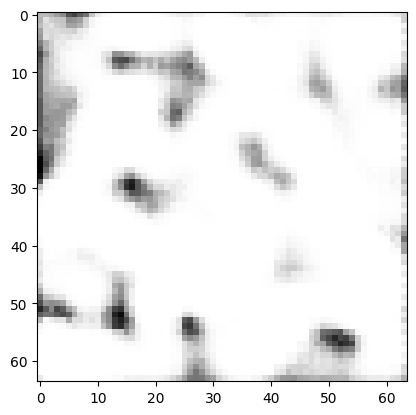

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 15.75it/s]


loss:  0.40895283222198486  l_d:  0.07656543701887131  l_e:  0.07656543701887131  l_g:  0.25582194328308105
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


loss:  0.43310022354125977  l_d:  0.09249082207679749  l_e:  0.09249082207679749  l_g:  0.2481185644865036
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


loss:  0.39148131012916565  l_d:  0.08048686385154724  l_e:  0.08048686385154724  l_g:  0.23050758242607117
Epoch 4 : 


100%|██████████| 50/50 [00:02<00:00, 16.67it/s]


loss:  0.43202298879623413  l_d:  0.08160072565078735  l_e:  0.08160072565078735  l_g:  0.2688215374946594
Epoch 5 : 


100%|██████████| 50/50 [00:02<00:00, 16.73it/s]


loss:  0.36275163292884827  l_d:  0.08208627998828888  l_e:  0.08208627998828888  l_g:  0.1985790729522705
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 15.31it/s]


loss:  0.38248512148857117  l_d:  0.0759563073515892  l_e:  0.0759563073515892  l_g:  0.23057250678539276
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 16.10it/s]


loss:  0.3522759675979614  l_d:  0.07326728850603104  l_e:  0.07326728850603104  l_g:  0.20574137568473816
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 14.63it/s]


loss:  0.31093907356262207  l_d:  0.07509060204029083  l_e:  0.07509060204029083  l_g:  0.1607578545808792
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


loss:  0.2811196446418762  l_d:  0.0718032494187355  l_e:  0.07180324196815491  l_g:  0.1375131607055664
Epoch 10 : 


100%|██████████| 50/50 [00:03<00:00, 15.60it/s]


loss:  0.5505781173706055  l_d:  0.142973393201828  l_e:  0.1429734081029892  l_g:  0.26463136076927185
Epoch 11 : 


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


loss:  0.5200783014297485  l_d:  0.15309958159923553  l_e:  0.15309958159923553  l_g:  0.21387910842895508
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


loss:  0.3837958574295044  l_d:  0.0807526558637619  l_e:  0.0807526558637619  l_g:  0.22229056060314178
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


loss:  0.42875897884368896  l_d:  0.07549184560775757  l_e:  0.07549184560775757  l_g:  0.27777528762817383
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


loss:  0.4014189839363098  l_d:  0.07318470627069473  l_e:  0.07318470627069473  l_g:  0.25504958629608154
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


loss:  0.41888436675071716  l_d:  0.08480556309223175  l_e:  0.08480556309223175  l_g:  0.24927324056625366
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 13.29it/s]


loss:  0.3523779809474945  l_d:  0.0745026171207428  l_e:  0.0745026171207428  l_g:  0.2033727467060089
Epoch 17 : 


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


loss:  0.3212597966194153  l_d:  0.07281175255775452  l_e:  0.07281174510717392  l_g:  0.17563629150390625
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


loss:  0.4472176432609558  l_d:  0.08594167232513428  l_e:  0.08594167232513428  l_g:  0.27533429861068726
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  0.33605000376701355  l_d:  0.09728993475437164  l_e:  0.09728993475437164  l_g:  0.14147013425827026
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


loss:  0.5763229727745056  l_d:  0.16095376014709473  l_e:  0.16095376014709473  l_g:  0.25441545248031616


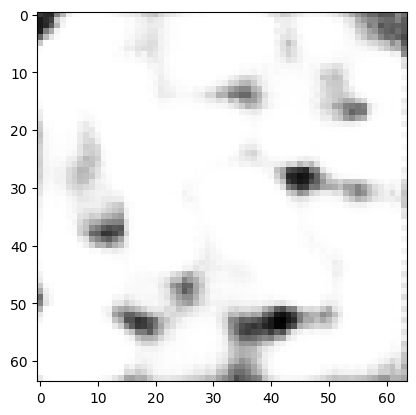

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 15.62it/s]


loss:  0.4199714660644531  l_d:  0.07131791114807129  l_e:  0.07131791114807129  l_g:  0.27733564376831055
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


loss:  0.3917614221572876  l_d:  0.07766963541507721  l_e:  0.07766963541507721  l_g:  0.23642215132713318
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


loss:  0.42383474111557007  l_d:  0.07225746661424637  l_e:  0.07225746661424637  l_g:  0.2793198227882385
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


loss:  0.40559878945350647  l_d:  0.07633106410503387  l_e:  0.07633105665445328  l_g:  0.2529366612434387
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


loss:  0.4225865602493286  l_d:  0.07440689951181412  l_e:  0.07440689951181412  l_g:  0.2737727761268616
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


loss:  0.4826768636703491  l_d:  0.09501975029706955  l_e:  0.09501975029706955  l_g:  0.29263734817504883
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 12.67it/s]


loss:  0.36002373695373535  l_d:  0.07915322482585907  l_e:  0.07915323227643967  l_g:  0.2017173022031784
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


loss:  0.43312889337539673  l_d:  0.10953184962272644  l_e:  0.10953184962272644  l_g:  0.21406519412994385
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


loss:  0.42929160594940186  l_d:  0.11474351584911346  l_e:  0.11474351584911346  l_g:  0.19980458915233612
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 14.76it/s]


loss:  0.47872114181518555  l_d:  0.11306476593017578  l_e:  0.11306476593017578  l_g:  0.252591609954834
Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


loss:  0.39456871151924133  l_d:  0.07001255452632904  l_e:  0.07001255452632904  l_g:  0.25454360246658325
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 12.81it/s]


loss:  0.2829224765300751  l_d:  0.0694626048207283  l_e:  0.0694626048207283  l_g:  0.14399726688861847
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


loss:  0.3416866958141327  l_d:  0.07332257926464081  l_e:  0.07332257926464081  l_g:  0.19504153728485107
Epoch 34 : 


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


loss:  0.4685818552970886  l_d:  0.07451789081096649  l_e:  0.07451789081096649  l_g:  0.31954607367515564
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


loss:  0.40334784984588623  l_d:  0.09073617309331894  l_e:  0.09073617309331894  l_g:  0.22187548875808716
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 16.61it/s]


loss:  0.43311217427253723  l_d:  0.08494125306606293  l_e:  0.08494125306606293  l_g:  0.2632296681404114
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


loss:  0.40921878814697266  l_d:  0.08477809280157089  l_e:  0.08477810025215149  l_g:  0.23966260254383087
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


loss:  0.4082109034061432  l_d:  0.07331852614879608  l_e:  0.07331852614879608  l_g:  0.261573851108551
Epoch 39 : 


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


loss:  0.3397834897041321  l_d:  0.07385823130607605  l_e:  0.07385823130607605  l_g:  0.19206704199314117
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 15.18it/s]


loss:  0.3087524175643921  l_d:  0.07207931578159332  l_e:  0.07207931578159332  l_g:  0.16459380090236664


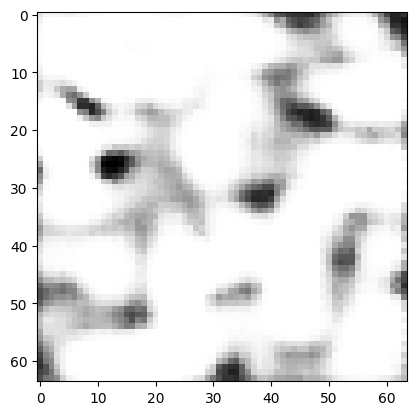

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 16.47it/s]


loss:  0.40715938806533813  l_d:  0.07001397013664246  l_e:  0.07001397013664246  l_g:  0.2671314477920532
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 15.15it/s]


loss:  0.290997713804245  l_d:  0.07152460515499115  l_e:  0.07152460515499115  l_g:  0.1479485034942627
Epoch 43 : 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


loss:  0.3242010772228241  l_d:  0.06960123777389526  l_e:  0.06960123777389526  l_g:  0.18499860167503357
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


loss:  0.35709524154663086  l_d:  0.08714162558317184  l_e:  0.08714162558317184  l_g:  0.18281200528144836
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 15.13it/s]


loss:  0.340737521648407  l_d:  0.0721515417098999  l_e:  0.0721515417098999  l_g:  0.19643443822860718
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 14.82it/s]


loss:  0.36399292945861816  l_d:  0.07520318776369095  l_e:  0.07520318031311035  l_g:  0.21358656883239746
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


loss:  0.6038579940795898  l_d:  0.15788140892982483  l_e:  0.15788140892982483  l_g:  0.2880951762199402
Epoch 48 : 


100%|██████████| 50/50 [00:03<00:00, 15.49it/s]


loss:  0.38334009051322937  l_d:  0.0781579315662384  l_e:  0.0781579315662384  l_g:  0.22702422738075256
Epoch 49 : 


100%|██████████| 50/50 [00:04<00:00, 12.44it/s]


loss:  0.2768605947494507  l_d:  0.07150115072727203  l_e:  0.07150115072727203  l_g:  0.1338583081960678
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


loss:  0.3209792375564575  l_d:  0.0721505731344223  l_e:  0.0721505731344223  l_g:  0.17667809128761292
Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


loss:  0.2593892514705658  l_d:  0.06812742352485657  l_e:  0.06812742352485657  l_g:  0.12313439697027206
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


loss:  0.40519705414772034  l_d:  0.06827527284622192  l_e:  0.06827527284622192  l_g:  0.2686465084552765
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 15.68it/s]


loss:  0.4062129259109497  l_d:  0.06791102886199951  l_e:  0.06791103631258011  l_g:  0.2703908681869507
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 15.70it/s]


loss:  0.36826759576797485  l_d:  0.07010158151388168  l_e:  0.07010157406330109  l_g:  0.22806444764137268
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 15.68it/s]


loss:  0.35850682854652405  l_d:  0.07646872103214264  l_e:  0.07646872103214264  l_g:  0.20556938648223877
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


loss:  0.316036581993103  l_d:  0.07008422166109085  l_e:  0.07008422166109085  l_g:  0.17586815357208252
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


loss:  0.4092189371585846  l_d:  0.0694841593503952  l_e:  0.0694841593503952  l_g:  0.2702506184577942
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 14.78it/s]


loss:  0.4198903739452362  l_d:  0.0705113336443901  l_e:  0.07051132619380951  l_g:  0.2788677215576172
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 12.70it/s]


loss:  0.38778889179229736  l_d:  0.07301044464111328  l_e:  0.07301044464111328  l_g:  0.2417680025100708
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 14.00it/s]


loss:  0.34101226925849915  l_d:  0.06799240410327911  l_e:  0.06799240410327911  l_g:  0.20502746105194092


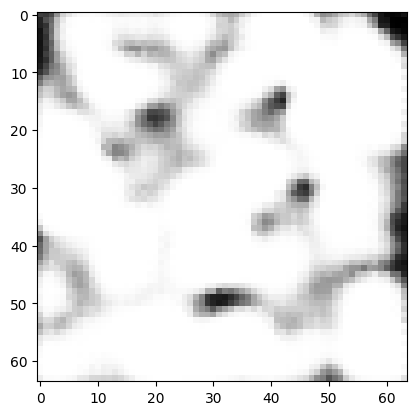

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


loss:  0.44806215167045593  l_d:  0.10614977777004242  l_e:  0.10614977777004242  l_g:  0.2357625961303711
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


loss:  0.3712189495563507  l_d:  0.08924053609371185  l_e:  0.08924052864313126  l_g:  0.192737877368927
Epoch 63 : 


100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


loss:  0.4625089764595032  l_d:  0.14526596665382385  l_e:  0.14526596665382385  l_g:  0.17197702825069427
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 15.75it/s]


loss:  0.40414324402809143  l_d:  0.08429038524627686  l_e:  0.08429038524627686  l_g:  0.23556247353553772
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


loss:  0.36878183484077454  l_d:  0.07252340018749237  l_e:  0.07252340018749237  l_g:  0.2237350344657898
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


loss:  0.2905197739601135  l_d:  0.06843775510787964  l_e:  0.06843775510787964  l_g:  0.15364424884319305
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


loss:  0.3744305372238159  l_d:  0.0676586851477623  l_e:  0.0676586851477623  l_g:  0.23911315202713013
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 14.67it/s]


loss:  0.36818766593933105  l_d:  0.07182986289262772  l_e:  0.07182986289262772  l_g:  0.22452792525291443
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


loss:  0.31876862049102783  l_d:  0.07868461310863495  l_e:  0.07868461310863495  l_g:  0.16139939427375793
Epoch 70 : 


100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


loss:  0.35001206398010254  l_d:  0.07342921197414398  l_e:  0.07342921197414398  l_g:  0.20315365493297577
Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


loss:  0.4005126357078552  l_d:  0.09474353492259979  l_e:  0.09474353492259979  l_g:  0.21102558076381683
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


loss:  0.41907739639282227  l_d:  0.07146406173706055  l_e:  0.07146406173706055  l_g:  0.27614927291870117
Epoch 73 : 


100%|██████████| 50/50 [00:04<00:00, 11.89it/s]


loss:  0.34410929679870605  l_d:  0.0697563886642456  l_e:  0.0697563886642456  l_g:  0.20459651947021484
Epoch 74 : 


100%|██████████| 50/50 [00:03<00:00, 14.92it/s]


loss:  0.3870158791542053  l_d:  0.06583074480295181  l_e:  0.06583074480295181  l_g:  0.2553543746471405
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  0.3876059949398041  l_d:  0.07269975543022156  l_e:  0.07269975543022156  l_g:  0.24220648407936096
Epoch 76 : 


100%|██████████| 50/50 [00:03<00:00, 16.32it/s]


loss:  0.38031983375549316  l_d:  0.06655634939670563  l_e:  0.06655634939670563  l_g:  0.24720712006092072
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


loss:  0.34426742792129517  l_d:  0.072117879986763  l_e:  0.072117879986763  l_g:  0.20003165304660797
Epoch 78 : 


100%|██████████| 50/50 [00:02<00:00, 16.82it/s]


loss:  0.363916277885437  l_d:  0.06868988275527954  l_e:  0.06868988275527954  l_g:  0.22653651237487793
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 15.60it/s]


loss:  0.29403895139694214  l_d:  0.06537891924381256  l_e:  0.06537891924381256  l_g:  0.16328111290931702
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


loss:  0.3661859631538391  l_d:  0.07670751959085464  l_e:  0.07670751959085464  l_g:  0.21277093887329102


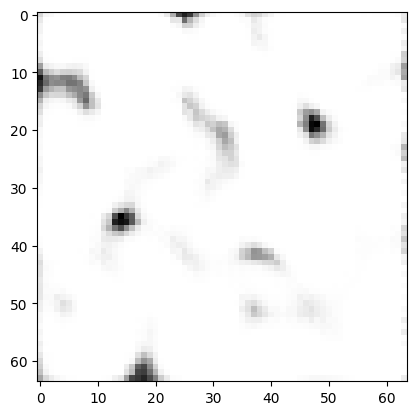

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 15.70it/s]


loss:  0.33224916458129883  l_d:  0.07206794619560242  l_e:  0.07206796109676361  l_g:  0.188113272190094
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 16.27it/s]


loss:  0.29364559054374695  l_d:  0.06962935626506805  l_e:  0.06962935626506805  l_g:  0.15438687801361084
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


loss:  0.4327481985092163  l_d:  0.09808839857578278  l_e:  0.09808839857578278  l_g:  0.23657140135765076
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


loss:  0.31313279271125793  l_d:  0.07568380981683731  l_e:  0.07568380981683731  l_g:  0.1617651730775833
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


loss:  0.32084453105926514  l_d:  0.0709768533706665  l_e:  0.0709768533706665  l_g:  0.17889082431793213
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


loss:  0.30957573652267456  l_d:  0.06666877865791321  l_e:  0.06666877865791321  l_g:  0.17623817920684814
Epoch 87 : 


100%|██████████| 50/50 [00:03<00:00, 15.17it/s]


loss:  0.3311115503311157  l_d:  0.07099022716283798  l_e:  0.07099022716283798  l_g:  0.18913109600543976
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


loss:  0.36136960983276367  l_d:  0.07762668281793594  l_e:  0.07762668281793594  l_g:  0.20611624419689178
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 15.73it/s]


loss:  0.3376295566558838  l_d:  0.06637322157621384  l_e:  0.06637322157621384  l_g:  0.2048831284046173
Epoch 90 : 


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


loss:  0.5807900428771973  l_d:  0.15388062596321106  l_e:  0.15388062596321106  l_g:  0.27302879095077515
Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 14.92it/s]


loss:  0.32093262672424316  l_d:  0.06816451251506805  l_e:  0.06816451251506805  l_g:  0.18460361659526825
Epoch 92 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  0.2975672781467438  l_d:  0.06859106570482254  l_e:  0.06859106570482254  l_g:  0.1603851467370987
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  0.35578930377960205  l_d:  0.07110245525836945  l_e:  0.07110245525836945  l_g:  0.21358439326286316
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


loss:  0.372441828250885  l_d:  0.06527650356292725  l_e:  0.06527650356292725  l_g:  0.2418888360261917
Epoch 95 : 


100%|██████████| 50/50 [00:03<00:00, 15.72it/s]


loss:  0.40174463391304016  l_d:  0.08152668178081512  l_e:  0.08152668178081512  l_g:  0.2386912703514099
Epoch 96 : 


100%|██████████| 50/50 [00:03<00:00, 15.58it/s]


loss:  0.37870681285858154  l_d:  0.06600038707256317  l_e:  0.06600038707256317  l_g:  0.2467060536146164
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


loss:  0.4337610602378845  l_d:  0.06631612032651901  l_e:  0.06631612032651901  l_g:  0.3011288046836853
Epoch 98 : 


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


loss:  0.4257229268550873  l_d:  0.07284767925739288  l_e:  0.07284767925739288  l_g:  0.2800275683403015
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


loss:  0.3973836898803711  l_d:  0.07855119556188583  l_e:  0.07855119556188583  l_g:  0.24028129875659943


In [7]:
train_d2c(100, 0.001, 1, 0.0000)

Epoch 0 : 


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


loss:  0.9473938345909119  l_d:  0.09869780391454697  l_e:  0.09869780391454697  l_g:  0.18749955296516418


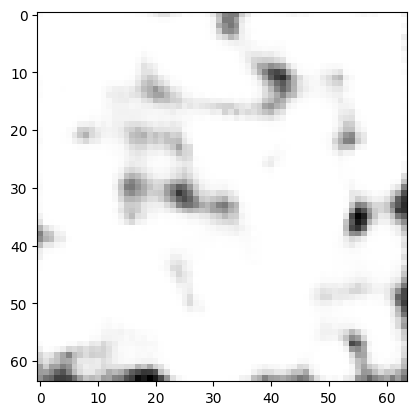

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 12.76it/s]


loss:  0.8619545698165894  l_d:  0.08244512975215912  l_e:  0.08244513720273972  l_g:  0.17426607012748718
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


loss:  0.9475983381271362  l_d:  0.08988655358552933  l_e:  0.08988654613494873  l_g:  0.1919563114643097
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 13.04it/s]


loss:  0.8915921449661255  l_d:  0.08249696344137192  l_e:  0.08249696344137192  l_g:  0.18164955079555511
Epoch 4 : 


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


loss:  0.8812285661697388  l_d:  0.09764714539051056  l_e:  0.09764714539051056  l_g:  0.17148357629776
Epoch 5 : 


100%|██████████| 50/50 [00:03<00:00, 12.58it/s]


loss:  0.7493417263031006  l_d:  0.08251398801803589  l_e:  0.08251398801803589  l_g:  0.1460784375667572
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


loss:  0.9437549710273743  l_d:  0.08745864033699036  l_e:  0.08745864033699036  l_g:  0.1922094225883484
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


loss:  0.9500453472137451  l_d:  0.08423002064228058  l_e:  0.08423002064228058  l_g:  0.1953963339328766
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


loss:  0.9321889281272888  l_d:  0.08690798282623291  l_e:  0.08690798282623291  l_g:  0.18959324061870575
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 12.82it/s]


loss:  1.1306896209716797  l_d:  0.13758894801139832  l_e:  0.13758894801139832  l_g:  0.21387794613838196
Epoch 10 : 


100%|██████████| 50/50 [00:04<00:00, 12.37it/s]


loss:  1.1774108409881592  l_d:  0.15894076228141785  l_e:  0.15894076228141785  l_g:  0.21488231420516968
Epoch 11 : 


100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


loss:  0.8553199172019958  l_d:  0.08715995401144028  l_e:  0.08715995401144028  l_g:  0.17024999856948853
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]


loss:  0.9164347648620605  l_d:  0.09283139556646347  l_e:  0.09283138811588287  l_g:  0.1826930046081543
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 13.25it/s]


loss:  1.0304961204528809  l_d:  0.1165546327829361  l_e:  0.1165546327829361  l_g:  0.19934670627117157
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  0.9893488883972168  l_d:  0.0838703066110611  l_e:  0.0838703066110611  l_g:  0.20540207624435425
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


loss:  0.8474112749099731  l_d:  0.09472357481718063  l_e:  0.09472357481718063  l_g:  0.16449102759361267
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  1.0127551555633545  l_d:  0.0887087807059288  l_e:  0.0887087807059288  l_g:  0.20883440971374512
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


loss:  0.8268169164657593  l_d:  0.08467806875705719  l_e:  0.08467806875705719  l_g:  0.16436520218849182
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


loss:  0.8214972019195557  l_d:  0.08928541094064713  l_e:  0.08928541094064713  l_g:  0.16073159873485565
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


loss:  0.934911847114563  l_d:  0.09047119319438934  l_e:  0.09047119319438934  l_g:  0.18849235773086548
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


loss:  1.29412841796875  l_d:  0.16643159091472626  l_e:  0.16643159091472626  l_g:  0.24031630158424377


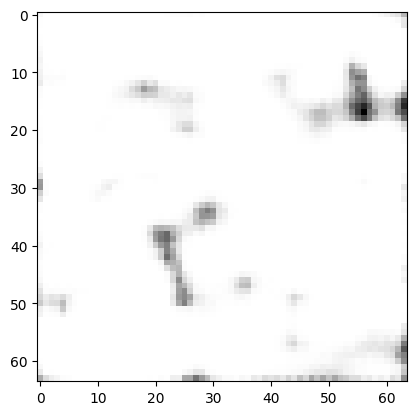

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


loss:  1.4590158462524414  l_d:  0.2942814826965332  l_e:  0.2942814826965332  l_g:  0.21761320531368256
Epoch 22 : 


100%|██████████| 50/50 [00:04<00:00, 12.35it/s]


loss:  0.8979662656784058  l_d:  0.16850101947784424  l_e:  0.16850103437900543  l_g:  0.14024105668067932
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


loss:  1.1663693189620972  l_d:  0.19281332194805145  l_e:  0.19281332194805145  l_g:  0.19518567621707916
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


loss:  0.8087167143821716  l_d:  0.09201693534851074  l_e:  0.09201693534851074  l_g:  0.15617071092128754
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


loss:  0.8559678792953491  l_d:  0.08907131850719452  l_e:  0.08907131850719452  l_g:  0.16945630311965942
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


loss:  0.922376275062561  l_d:  0.08480576425790787  l_e:  0.08480576425790787  l_g:  0.18819119036197662
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 13.12it/s]


loss:  0.8684807419776917  l_d:  0.08429229259490967  l_e:  0.08429229259490967  l_g:  0.17497403919696808
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


loss:  0.9763821363449097  l_d:  0.08567117154598236  l_e:  0.08567117899656296  l_g:  0.20125994086265564
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


loss:  1.2385176420211792  l_d:  0.2548791468143463  l_e:  0.2548791766166687  l_g:  0.18218982219696045
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


loss:  0.8979204893112183  l_d:  0.08426956087350845  l_e:  0.08426956087350845  l_g:  0.18234534561634064
Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


loss:  0.7790360450744629  l_d:  0.0953889936208725  l_e:  0.0953889936208725  l_g:  0.14706450700759888
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 13.66it/s]


loss:  0.9757198095321655  l_d:  0.11108764261007309  l_e:  0.11108763515949249  l_g:  0.18838612735271454
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


loss:  0.6891417503356934  l_d:  0.10599224269390106  l_e:  0.10599224269390106  l_g:  0.11928930878639221
Epoch 34 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  0.7177053689956665  l_d:  0.09128494560718536  l_e:  0.09128494560718536  l_g:  0.13378386199474335
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


loss:  0.8089662194252014  l_d:  0.08903038501739502  l_e:  0.08903038501739502  l_g:  0.15772636234760284
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 14.15it/s]


loss:  1.0187301635742188  l_d:  0.0909011960029602  l_e:  0.0909011960029602  l_g:  0.20923194289207458
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


loss:  1.11463463306427  l_d:  0.1495983600616455  l_e:  0.1495983600616455  l_g:  0.20385947823524475
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


loss:  0.7862843871116638  l_d:  0.085332952439785  l_e:  0.085332952439785  l_g:  0.15390461683273315
Epoch 39 : 


100%|██████████| 50/50 [00:03<00:00, 14.15it/s]


loss:  0.8231180906295776  l_d:  0.10006193816661835  l_e:  0.10006193816661835  l_g:  0.15574854612350464
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 14.15it/s]


loss:  1.0479881763458252  l_d:  0.08613714575767517  l_e:  0.08613714575767517  l_g:  0.2189284712076187


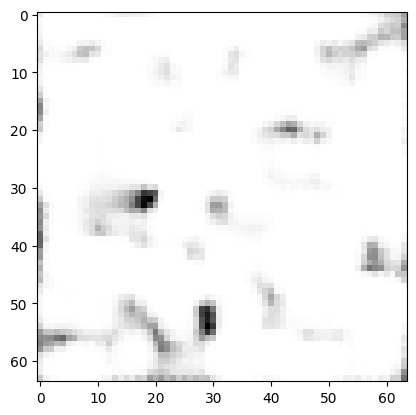

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


loss:  0.7717949151992798  l_d:  0.11353861540555954  l_e:  0.11353860795497894  l_g:  0.13617941737174988
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


loss:  1.0946869850158691  l_d:  0.25394800305366516  l_e:  0.25394800305366516  l_g:  0.1466977596282959
Epoch 43 : 


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


loss:  0.7553199529647827  l_d:  0.08589517325162888  l_e:  0.08589516580104828  l_g:  0.14588241279125214
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


loss:  0.6310437917709351  l_d:  0.08815930783748627  l_e:  0.08815930783748627  l_g:  0.11368129402399063
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


loss:  1.6269209384918213  l_d:  0.3312358260154724  l_e:  0.3312358260154724  l_g:  0.24111230671405792
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


loss:  0.8012190461158752  l_d:  0.11685542017221451  l_e:  0.11685542017221451  l_g:  0.14187705516815186
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


loss:  0.8593083024024963  l_d:  0.09312886744737625  l_e:  0.09312886744737625  l_g:  0.16826264560222626
Epoch 48 : 


100%|██████████| 50/50 [00:04<00:00, 12.38it/s]


loss:  1.0384140014648438  l_d:  0.08758583664894104  l_e:  0.08758583664894104  l_g:  0.21581056714057922
Epoch 49 : 


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


loss:  0.8451220989227295  l_d:  0.09742587804794312  l_e:  0.09742587804794312  l_g:  0.16256758570671082
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 12.73it/s]


loss:  0.9347810745239258  l_d:  0.11533147096633911  l_e:  0.11533147096633911  l_g:  0.1760295331478119
Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


loss:  1.0419753789901733  l_d:  0.09271329641342163  l_e:  0.09271329641342163  l_g:  0.21413719654083252
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


loss:  0.8312505483627319  l_d:  0.09434568136930466  l_e:  0.09434567391872406  l_g:  0.16063979268074036
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


loss:  1.1261910200119019  l_d:  0.08972257375717163  l_e:  0.08972257375717163  l_g:  0.23668646812438965
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


loss:  1.0021785497665405  l_d:  0.09730923920869827  l_e:  0.09730923175811768  l_g:  0.2018900215625763
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


loss:  1.093088984489441  l_d:  0.13772350549697876  l_e:  0.13772350549697876  l_g:  0.20441049337387085
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


loss:  0.6772075295448303  l_d:  0.08999228477478027  l_e:  0.08999228477478027  l_g:  0.12430573999881744
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


loss:  0.8476657867431641  l_d:  0.10070227831602097  l_e:  0.10070227831602097  l_g:  0.16156530380249023
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 14.93it/s]


loss:  0.9928909540176392  l_d:  0.08881263434886932  l_e:  0.08881263434886932  l_g:  0.20381641387939453
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


loss:  1.2298386096954346  l_d:  0.15790654718875885  l_e:  0.15790656208992004  l_g:  0.22850638628005981
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 15.34it/s]


loss:  1.0057860612869263  l_d:  0.08418821543455124  l_e:  0.08418820798397064  l_g:  0.20935240387916565


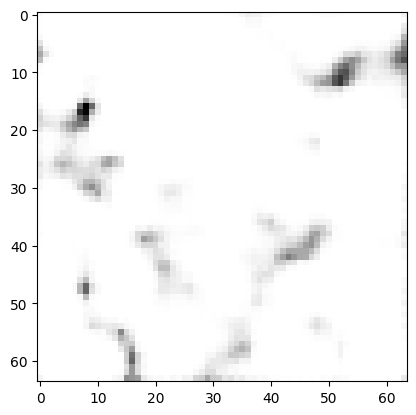

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


loss:  1.305983543395996  l_d:  0.1686960756778717  l_e:  0.1686960756778717  l_g:  0.24214786291122437
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


loss:  0.6694802641868591  l_d:  0.10877916216850281  l_e:  0.10877916216850281  l_g:  0.11298048496246338
Epoch 63 : 


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


loss:  0.9309342503547668  l_d:  0.08885204792022705  l_e:  0.08885204792022705  l_g:  0.18830753862857819
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


loss:  0.9125315546989441  l_d:  0.1104380190372467  l_e:  0.1104380190372467  l_g:  0.17291387915611267
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


loss:  0.8260554671287537  l_d:  0.14643141627311707  l_e:  0.14643141627311707  l_g:  0.13329815864562988
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


loss:  0.7128690481185913  l_d:  0.08572141826152802  l_e:  0.08572141826152802  l_g:  0.13535656034946442
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 13.59it/s]


loss:  0.7803900241851807  l_d:  0.0916147232055664  l_e:  0.0916147232055664  l_g:  0.14929014444351196
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


loss:  0.6976848840713501  l_d:  0.08863680064678192  l_e:  0.08863679319620132  l_g:  0.13010281324386597
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


loss:  0.8726304173469543  l_d:  0.1243375912308693  l_e:  0.1243375912308693  l_g:  0.15598881244659424
Epoch 70 : 


100%|██████████| 50/50 [00:03<00:00, 14.83it/s]


loss:  1.0463016033172607  l_d:  0.08654935657978058  l_e:  0.08654935657978058  l_g:  0.2183007299900055
Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


loss:  1.273278832435608  l_d:  0.2652694284915924  l_e:  0.2652694284915924  l_g:  0.18568499386310577
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


loss:  0.9665954113006592  l_d:  0.08725964277982712  l_e:  0.08725964277982712  l_g:  0.19801902770996094
Epoch 73 : 


100%|██████████| 50/50 [00:04<00:00, 12.16it/s]


loss:  0.6721011996269226  l_d:  0.11156033724546432  l_e:  0.11156033724546432  l_g:  0.11224512755870819
Epoch 74 : 


100%|██████████| 50/50 [00:04<00:00, 11.94it/s]


loss:  0.9326091408729553  l_d:  0.09611299633979797  l_e:  0.09611299633979797  l_g:  0.18509578704833984
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


loss:  0.8023226261138916  l_d:  0.08512340486049652  l_e:  0.08512340486049652  l_g:  0.15801894664764404
Epoch 76 : 


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


loss:  1.0089306831359863  l_d:  0.1855936199426651  l_e:  0.1855936050415039  l_g:  0.15943586826324463
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 14.17it/s]


loss:  1.0371711254119873  l_d:  0.0862502008676529  l_e:  0.0862502008676529  l_g:  0.21616768836975098
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


loss:  0.8306190967559814  l_d:  0.08500371873378754  l_e:  0.08500371873378754  l_g:  0.165152907371521
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


loss:  1.0991290807724  l_d:  0.08591783046722412  l_e:  0.08591783046722412  l_g:  0.23182335495948792
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 12.81it/s]


loss:  0.8050886392593384  l_d:  0.09268294274806976  l_e:  0.09268294274806976  l_g:  0.1549306958913803


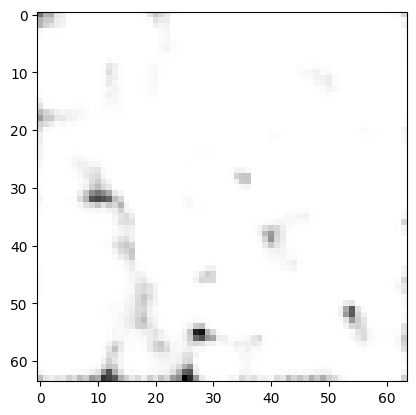

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  1.1600772142410278  l_d:  0.0955100879073143  l_e:  0.0955100879073143  l_g:  0.2422642707824707
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 13.28it/s]


loss:  0.8645879626274109  l_d:  0.13272035121917725  l_e:  0.13272035121917725  l_g:  0.1497868150472641
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


loss:  0.7839674353599548  l_d:  0.09202101826667786  l_e:  0.09202102571725845  l_g:  0.14998134970664978
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  1.2370654344558716  l_d:  0.1558992564678192  l_e:  0.1558992564678192  l_g:  0.2313167303800583
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


loss:  0.8306835293769836  l_d:  0.09066671133041382  l_e:  0.09066671133041382  l_g:  0.162337526679039
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 13.66it/s]


loss:  0.9429949522018433  l_d:  0.18985003232955933  l_e:  0.18985003232955933  l_g:  0.14082372188568115
Epoch 87 : 


100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


loss:  0.7265819311141968  l_d:  0.08801839500665665  l_e:  0.08801840245723724  l_g:  0.13763627409934998
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


loss:  0.9323911070823669  l_d:  0.08923608064651489  l_e:  0.08923608064651489  l_g:  0.1884797364473343
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


loss:  0.9353746771812439  l_d:  0.08762034773826599  l_e:  0.08762034773826599  l_g:  0.19003349542617798
Epoch 90 : 


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


loss:  0.8366389274597168  l_d:  0.19160692393779755  l_e:  0.19160693883895874  l_g:  0.11335625499486923
Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


loss:  0.6589782238006592  l_d:  0.10198772698640823  l_e:  0.10198771953582764  l_g:  0.11375068873167038
Epoch 92 : 


100%|██████████| 50/50 [00:04<00:00, 12.37it/s]


loss:  0.761664628982544  l_d:  0.11160425841808319  l_e:  0.11160425841808319  l_g:  0.1346140205860138
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


loss:  0.6688529253005981  l_d:  0.08593147993087769  l_e:  0.08593147993087769  l_g:  0.1242474839091301
Epoch 94 : 


100%|██████████| 50/50 [00:04<00:00, 12.28it/s]


loss:  0.8747029900550842  l_d:  0.21910789608955383  l_e:  0.21910789608955383  l_g:  0.10912179946899414
Epoch 95 : 


100%|██████████| 50/50 [00:04<00:00, 11.86it/s]


loss:  0.6742785573005676  l_d:  0.09010642021894455  l_e:  0.09010642021894455  l_g:  0.12351642549037933
Epoch 96 : 


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


loss:  0.6036535501480103  l_d:  0.08674107491970062  l_e:  0.08674107491970062  l_g:  0.10754285752773285
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  1.0074386596679688  l_d:  0.08914073556661606  l_e:  0.08914072811603546  l_g:  0.20728930830955505
Epoch 98 : 


100%|██████████| 50/50 [00:04<00:00, 12.45it/s]


loss:  1.068650245666504  l_d:  0.18124297261238098  l_e:  0.18124297261238098  l_g:  0.17654109001159668
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


loss:  0.8293544054031372  l_d:  0.0905141830444336  l_e:  0.0905141830444336  l_g:  0.1620815098285675
Epoch 100 : 


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


loss:  0.9150018095970154  l_d:  0.08807128667831421  l_e:  0.08807128667831421  l_g:  0.18471480906009674


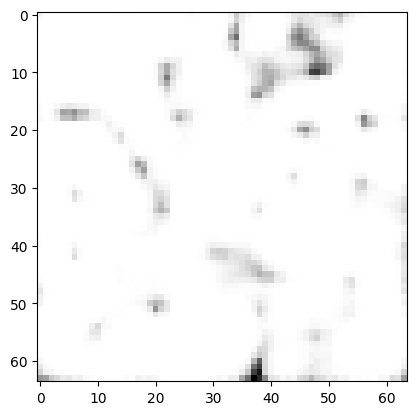

Epoch 101 : 


100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


loss:  0.8901060819625854  l_d:  0.08775191009044647  l_e:  0.08775191009044647  l_g:  0.17865055799484253
Epoch 102 : 


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


loss:  0.5695298910140991  l_d:  0.08547520637512207  l_e:  0.08547520637512207  l_g:  0.09964486956596375
Epoch 103 : 


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


loss:  0.903762698173523  l_d:  0.1145416647195816  l_e:  0.1145416647195816  l_g:  0.16866983473300934
Epoch 104 : 


100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


loss:  0.5860267877578735  l_d:  0.08699636161327362  l_e:  0.08699636161327362  l_g:  0.10300850868225098
Epoch 105 : 


100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


loss:  0.9598316550254822  l_d:  0.11716992408037186  l_e:  0.11716991662979126  l_g:  0.18137295544147491
Epoch 106 : 


100%|██████████| 50/50 [00:03<00:00, 13.06it/s]


loss:  1.11967933177948  l_d:  0.08599688112735748  l_e:  0.08599688112735748  l_g:  0.23692139983177185
Epoch 107 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  0.5828158855438232  l_d:  0.08900294452905655  l_e:  0.08900294452905655  l_g:  0.10120250284671783
Epoch 108 : 


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


loss:  0.8017405867576599  l_d:  0.08790310472249985  l_e:  0.08790311217308044  l_g:  0.15648359060287476
Epoch 109 : 


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


loss:  1.0571017265319824  l_d:  0.10482792556285858  l_e:  0.10482793301343918  l_g:  0.2118614763021469
Epoch 110 : 


100%|██████████| 50/50 [00:04<00:00, 12.03it/s]


loss:  0.8304647207260132  l_d:  0.08936284482479095  l_e:  0.08936283737421036  l_g:  0.16293475031852722
Epoch 111 : 


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


loss:  1.004900574684143  l_d:  0.10219375044107437  l_e:  0.10219374299049377  l_g:  0.20012827217578888
Epoch 112 : 


100%|██████████| 50/50 [00:04<00:00, 12.36it/s]


loss:  0.869944155216217  l_d:  0.09930086135864258  l_e:  0.09930086135864258  l_g:  0.16783560812473297
Epoch 113 : 


100%|██████████| 50/50 [00:04<00:00, 11.60it/s]


loss:  0.9057607650756836  l_d:  0.09893978387117386  l_e:  0.09893978387117386  l_g:  0.17697030305862427
Epoch 114 : 


100%|██████████| 50/50 [00:03<00:00, 13.57it/s]


loss:  0.8523684144020081  l_d:  0.10218450427055359  l_e:  0.10218450427055359  l_g:  0.16199985146522522
Epoch 115 : 


100%|██████████| 50/50 [00:03<00:00, 12.59it/s]


loss:  1.2135157585144043  l_d:  0.08797803521156311  l_e:  0.08797803521156311  l_g:  0.2593899369239807
Epoch 116 : 


100%|██████████| 50/50 [00:03<00:00, 12.76it/s]


loss:  0.9795746803283691  l_d:  0.10073257237672806  l_e:  0.10073257237672806  l_g:  0.19452738761901855
Epoch 117 : 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


loss:  1.3071657419204712  l_d:  0.21924471855163574  l_e:  0.21924471855163574  l_g:  0.21716907620429993
Epoch 118 : 


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


loss:  0.815918505191803  l_d:  0.08676975965499878  l_e:  0.08676975965499878  l_g:  0.16059474647045135
Epoch 119 : 


100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


loss:  0.9023378491401672  l_d:  0.10967504978179932  l_e:  0.10967504233121872  l_g:  0.17074693739414215
Epoch 120 : 


100%|██████████| 50/50 [00:03<00:00, 14.26it/s]


loss:  0.988480269908905  l_d:  0.0895550549030304  l_e:  0.0895550549030304  l_g:  0.20234254002571106


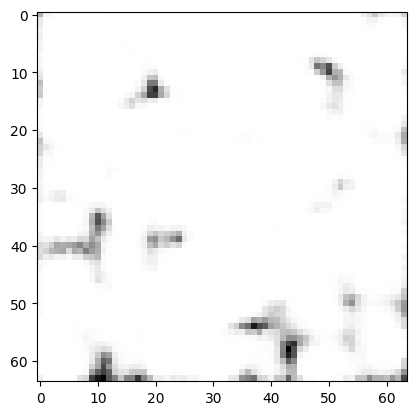

Epoch 121 : 


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


loss:  0.6389732360839844  l_d:  0.08495175838470459  l_e:  0.08495175838470459  l_g:  0.1172674298286438
Epoch 122 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  0.7035303711891174  l_d:  0.08884140849113464  l_e:  0.08884140849113464  l_g:  0.13146188855171204
Epoch 123 : 


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


loss:  1.140216588973999  l_d:  0.10244512557983398  l_e:  0.10244512557983398  l_g:  0.23383156955242157
Epoch 124 : 


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


loss:  0.8101165890693665  l_d:  0.11197814345359802  l_e:  0.11197814345359802  l_g:  0.1465400755405426
Epoch 125 : 


100%|██████████| 50/50 [00:04<00:00, 11.81it/s]


loss:  0.753230094909668  l_d:  0.0876079797744751  l_e:  0.0876079797744751  l_g:  0.14450353384017944
Epoch 126 : 


100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


loss:  0.813998818397522  l_d:  0.1067301481962204  l_e:  0.1067301481962204  l_g:  0.1501346379518509
Epoch 127 : 


100%|██████████| 50/50 [00:04<00:00, 12.10it/s]


loss:  0.7495021820068359  l_d:  0.08832228928804398  l_e:  0.08832228928804398  l_g:  0.1432144045829773
Epoch 128 : 


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


loss:  1.0022244453430176  l_d:  0.09166686981916428  l_e:  0.09166686981916428  l_g:  0.20472267270088196
Epoch 129 : 


100%|██████████| 50/50 [00:04<00:00, 12.09it/s]


loss:  0.9356048107147217  l_d:  0.09140356630086899  l_e:  0.09140356630086899  l_g:  0.18819941580295563
Epoch 130 : 


100%|██████████| 50/50 [00:04<00:00, 12.43it/s]


loss:  0.8375332355499268  l_d:  0.0911523848772049  l_e:  0.0911523848772049  l_g:  0.16380712389945984
Epoch 131 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  0.8306865096092224  l_d:  0.08623518794775009  l_e:  0.08623518794775009  l_g:  0.16455402970314026
Epoch 132 : 


100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


loss:  1.0409889221191406  l_d:  0.12138330936431885  l_e:  0.12138330936431885  l_g:  0.19955556094646454
Epoch 133 : 


100%|██████████| 50/50 [00:03<00:00, 12.54it/s]


loss:  1.2426609992980957  l_d:  0.3015381097793579  l_e:  0.3015381097793579  l_g:  0.15989620983600616
Epoch 134 : 


100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


loss:  1.05087411403656  l_d:  0.148456871509552  l_e:  0.148456871509552  l_g:  0.188490092754364
Epoch 135 : 


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


loss:  1.185124397277832  l_d:  0.08993518352508545  l_e:  0.08993518352508545  l_g:  0.2513135075569153
Epoch 136 : 


100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


loss:  0.7478153705596924  l_d:  0.09426606446504593  l_e:  0.09426605701446533  l_g:  0.13982081413269043
Epoch 137 : 


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


loss:  0.5985440611839294  l_d:  0.08900274336338043  l_e:  0.08900274336338043  l_g:  0.10513464361429214
Epoch 138 : 


100%|██████████| 50/50 [00:03<00:00, 12.78it/s]


loss:  0.8381365537643433  l_d:  0.1246802881360054  l_e:  0.1246802806854248  l_g:  0.1471939980983734
Epoch 139 : 


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


loss:  0.726416289806366  l_d:  0.08889517188072205  l_e:  0.08889517188072205  l_g:  0.13715648651123047
Epoch 140 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  0.5972906947135925  l_d:  0.08874014019966125  l_e:  0.08874014019966125  l_g:  0.1049526035785675


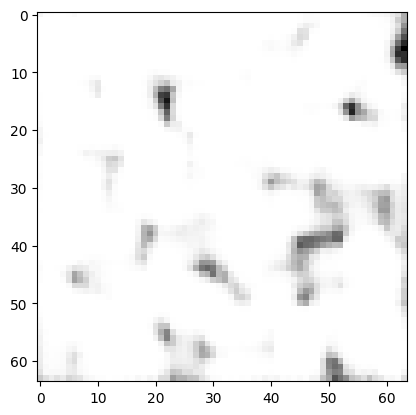

Epoch 141 : 


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


loss:  0.994878888130188  l_d:  0.12156178057193756  l_e:  0.12156177312135696  l_g:  0.1879388391971588
Epoch 142 : 


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


loss:  0.6952964663505554  l_d:  0.08688939362764359  l_e:  0.08688938617706299  l_g:  0.13037942349910736
Epoch 143 : 


100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


loss:  0.5866620540618896  l_d:  0.08852638304233551  l_e:  0.0885263979434967  l_g:  0.10240231454372406
Epoch 144 : 


100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


loss:  1.167788028717041  l_d:  0.08781488239765167  l_e:  0.08781488239765167  l_g:  0.24803955852985382
Epoch 145 : 


100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


loss:  0.9872393012046814  l_d:  0.0862986147403717  l_e:  0.0862986147403717  l_g:  0.2036605179309845
Epoch 146 : 


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


loss:  0.8283880352973938  l_d:  0.0901237428188324  l_e:  0.0901237428188324  l_g:  0.16203513741493225
Epoch 147 : 


100%|██████████| 50/50 [00:03<00:00, 13.76it/s]


loss:  0.9178034663200378  l_d:  0.09822210669517517  l_e:  0.09822210669517517  l_g:  0.18033981323242188
Epoch 148 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  0.7538575530052185  l_d:  0.08558949828147888  l_e:  0.08558949828147888  l_g:  0.14566963911056519
Epoch 149 : 


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


loss:  1.0890476703643799  l_d:  0.19073474407196045  l_e:  0.19073474407196045  l_g:  0.17689456045627594
Epoch 150 : 


100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


loss:  0.7212501764297485  l_d:  0.09311534464359283  l_e:  0.09311534464359283  l_g:  0.1337548792362213
Epoch 151 : 


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


loss:  1.238767147064209  l_d:  0.08540189266204834  l_e:  0.08540189266204834  l_g:  0.2669908404350281
Epoch 152 : 


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


loss:  0.6903400421142578  l_d:  0.08945560455322266  l_e:  0.08945560455322266  l_g:  0.12785720825195312
Epoch 153 : 


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


loss:  0.8829641342163086  l_d:  0.08664809912443161  l_e:  0.08664810657501221  l_g:  0.17741698026657104
Epoch 154 : 


100%|██████████| 50/50 [00:03<00:00, 13.43it/s]


loss:  0.9775370359420776  l_d:  0.08921341598033905  l_e:  0.08921341598033905  l_g:  0.1997775435447693
Epoch 155 : 


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


loss:  0.7202564477920532  l_d:  0.08430523425340652  l_e:  0.08430523425340652  l_g:  0.13791149854660034
Epoch 156 : 


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


loss:  0.8411877155303955  l_d:  0.08526657521724701  l_e:  0.08526656776666641  l_g:  0.16766363382339478
Epoch 157 : 


100%|██████████| 50/50 [00:04<00:00, 11.87it/s]


loss:  0.8449437022209167  l_d:  0.1731848567724228  l_e:  0.1731848567724228  l_g:  0.12464349716901779
Epoch 158 : 


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


loss:  0.6328142285346985  l_d:  0.10170871019363403  l_e:  0.10170871019363403  l_g:  0.1073492020368576
Epoch 159 : 


100%|██████████| 50/50 [00:03<00:00, 12.99it/s]


loss:  0.889647364616394  l_d:  0.08842363953590393  l_e:  0.08842363953590393  l_g:  0.17820002138614655
Epoch 160 : 


100%|██████████| 50/50 [00:03<00:00, 13.12it/s]


loss:  0.7781027555465698  l_d:  0.08885946124792099  l_e:  0.0888594537973404  l_g:  0.15009595453739166


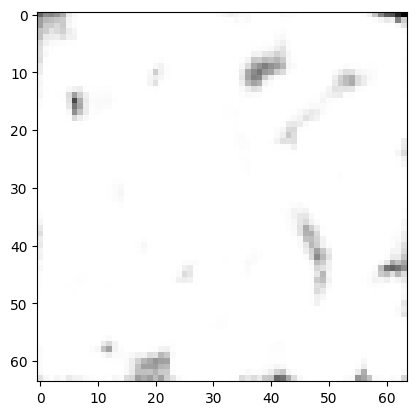

Epoch 161 : 


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


loss:  1.0600817203521729  l_d:  0.10406436026096344  l_e:  0.10406436026096344  l_g:  0.2129882425069809
Epoch 162 : 


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


loss:  0.8148692846298218  l_d:  0.1327541321516037  l_e:  0.1327541321516037  l_g:  0.137340247631073
Epoch 163 : 


100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


loss:  0.8332215547561646  l_d:  0.10907858610153198  l_e:  0.10907858610153198  l_g:  0.15376609563827515
Epoch 164 : 


100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


loss:  0.8136917948722839  l_d:  0.08728309720754623  l_e:  0.08728309720754623  l_g:  0.15978139638900757
Epoch 165 : 


100%|██████████| 50/50 [00:03<00:00, 13.23it/s]


loss:  0.6608003377914429  l_d:  0.09442444145679474  l_e:  0.09442444145679474  l_g:  0.11798786371946335
Epoch 166 : 


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


loss:  0.6401379704475403  l_d:  0.08548260480165482  l_e:  0.08548260480165482  l_g:  0.11729319393634796
Epoch 167 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  1.1756958961486816  l_d:  0.23043036460876465  l_e:  0.23043034970760345  l_g:  0.1787087768316269
Epoch 168 : 


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


loss:  0.9411998987197876  l_d:  0.08981011807918549  l_e:  0.08981011807918549  l_g:  0.19039490818977356
Epoch 169 : 


100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


loss:  0.650618851184845  l_d:  0.08593639731407166  l_e:  0.08593641221523285  l_g:  0.11968650668859482
Epoch 170 : 


100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


loss:  0.6059125065803528  l_d:  0.08829246461391449  l_e:  0.08829246461391449  l_g:  0.10733189433813095
Epoch 171 : 


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


loss:  0.7709757089614868  l_d:  0.09106108546257019  l_e:  0.09106108546257019  l_g:  0.1472133845090866
Epoch 172 : 


100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


loss:  0.7758077383041382  l_d:  0.09088154137134552  l_e:  0.09088154137134552  l_g:  0.14851117134094238
Epoch 173 : 


100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


loss:  0.6554003953933716  l_d:  0.10805974900722504  l_e:  0.10805974900722504  l_g:  0.10982021689414978
Epoch 174 : 


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


loss:  1.044904351234436  l_d:  0.2067962884902954  l_e:  0.2067963182926178  l_g:  0.1578279286623001
Epoch 175 : 


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


loss:  0.7725750207901001  l_d:  0.09090350568294525  l_e:  0.09090350568294525  l_g:  0.1476919949054718
Epoch 176 : 


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


loss:  0.7101174592971802  l_d:  0.08837521076202393  l_e:  0.08837521076202393  l_g:  0.13334175944328308
Epoch 177 : 


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


loss:  0.6901319026947021  l_d:  0.09515892714262009  l_e:  0.09515893459320068  l_g:  0.1249535083770752
Epoch 178 : 


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


loss:  0.7056311368942261  l_d:  0.089654840528965  l_e:  0.0896548330783844  l_g:  0.13158036768436432
Epoch 179 : 


100%|██████████| 50/50 [00:03<00:00, 14.53it/s]


loss:  0.7797489166259766  l_d:  0.13836851716041565  l_e:  0.13836851716041565  l_g:  0.12575297057628632
Epoch 180 : 


100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


loss:  0.7335149645805359  l_d:  0.09508389234542847  l_e:  0.09508389234542847  l_g:  0.13583679497241974


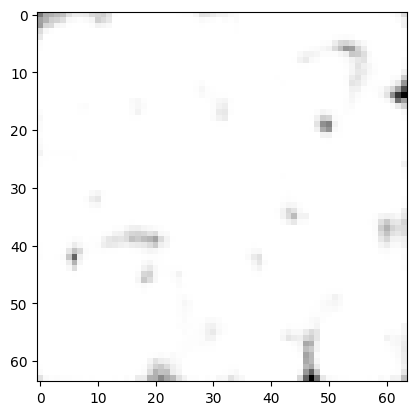

Epoch 181 : 


100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


loss:  0.8487839698791504  l_d:  0.09278301149606705  l_e:  0.09278301894664764  l_g:  0.16580447554588318
Epoch 182 : 


100%|██████████| 50/50 [00:03<00:00, 12.95it/s]


loss:  0.6465599536895752  l_d:  0.08784227073192596  l_e:  0.08784227073192596  l_g:  0.11771886050701141
Epoch 183 : 


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


loss:  0.7914674878120422  l_d:  0.10252681374549866  l_e:  0.10252680629491806  l_g:  0.14660346508026123
Epoch 184 : 


100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


loss:  0.9953421354293823  l_d:  0.08975423872470856  l_e:  0.08975423872470856  l_g:  0.2039584219455719
Epoch 185 : 


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


loss:  0.7495888471603394  l_d:  0.08536756038665771  l_e:  0.08536756038665771  l_g:  0.14471343159675598
Epoch 186 : 


100%|██████████| 50/50 [00:03<00:00, 13.76it/s]


loss:  0.9104286432266235  l_d:  0.09326289594173431  l_e:  0.09326288849115372  l_g:  0.18097570538520813
Epoch 187 : 


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


loss:  1.1476854085922241  l_d:  0.0903664082288742  l_e:  0.0903664082288742  l_g:  0.24173815548419952
Epoch 188 : 


100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


loss:  1.1373181343078613  l_d:  0.08572228252887726  l_e:  0.08572228252887726  l_g:  0.2414683848619461
Epoch 189 : 


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


loss:  0.8079687356948853  l_d:  0.11502403020858765  l_e:  0.11502403020858765  l_g:  0.1444801688194275
Epoch 190 : 


100%|██████████| 50/50 [00:03<00:00, 12.89it/s]


loss:  1.0262451171875  l_d:  0.09148244559764862  l_e:  0.09148244559764862  l_g:  0.2108200490474701
Epoch 191 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  0.874242901802063  l_d:  0.09423802047967911  l_e:  0.0942380279302597  l_g:  0.1714417040348053
Epoch 192 : 


100%|██████████| 50/50 [00:04<00:00, 12.32it/s]


loss:  1.1169524192810059  l_d:  0.08602732419967651  l_e:  0.08602732419967651  l_g:  0.23622442781925201
Epoch 193 : 


100%|██████████| 50/50 [00:03<00:00, 12.99it/s]


loss:  0.6409170627593994  l_d:  0.08857430517673492  l_e:  0.08857430517673492  l_g:  0.11594211310148239
Epoch 194 : 


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


loss:  1.5341248512268066  l_d:  0.2489663064479828  l_e:  0.2489663064479828  l_g:  0.25904807448387146
Epoch 195 : 


100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


loss:  0.9835963845252991  l_d:  0.08685676008462906  l_e:  0.08685676008462906  l_g:  0.20247071981430054
Epoch 196 : 


100%|██████████| 50/50 [00:03<00:00, 13.95it/s]


loss:  0.8022078275680542  l_d:  0.08594273030757904  l_e:  0.08594273030757904  l_g:  0.15758058428764343
Epoch 197 : 


100%|██████████| 50/50 [00:03<00:00, 14.22it/s]


loss:  0.9354705810546875  l_d:  0.08858013153076172  l_e:  0.08858013153076172  l_g:  0.18957757949829102
Epoch 198 : 


100%|██████████| 50/50 [00:03<00:00, 13.17it/s]


loss:  0.7945247888565063  l_d:  0.09238006174564362  l_e:  0.09238006919622421  l_g:  0.15244115889072418
Epoch 199 : 


100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


loss:  1.2391183376312256  l_d:  0.2547004520893097  l_e:  0.2547004520893097  l_g:  0.18242934346199036


In [6]:
train_d2c(200, 0.0005, 1, 0.00001, 4)

Epoch 0 : 


100%|██████████| 50/50 [00:04<00:00, 12.05it/s]


loss:  0.7366665601730347  l_d:  0.08629042655229568  l_e:  0.08629042655229568  l_g:  0.14102143049240112


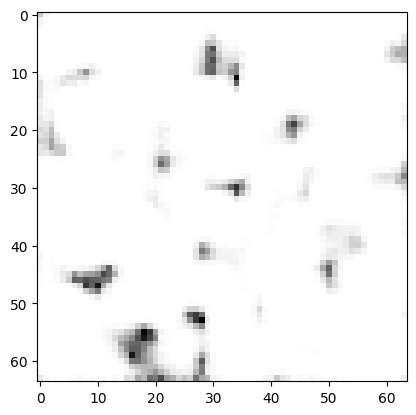

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


loss:  0.6602221131324768  l_d:  0.10832099616527557  l_e:  0.10832099616527557  l_g:  0.11089503020048141
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  0.6690876483917236  l_d:  0.09961509704589844  l_e:  0.09961509704589844  l_g:  0.11746437102556229
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


loss:  0.8716457486152649  l_d:  0.0849461555480957  l_e:  0.0849461555480957  l_g:  0.17543835937976837
Epoch 4 : 


100%|██████████| 50/50 [00:03<00:00, 13.60it/s]


loss:  1.0220682621002197  l_d:  0.08690837770700455  l_e:  0.08690837770700455  l_g:  0.21206286549568176
Epoch 5 : 


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


loss:  0.8248786926269531  l_d:  0.09354858100414276  l_e:  0.09354858100414276  l_g:  0.1594453752040863
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 12.64it/s]


loss:  0.750960111618042  l_d:  0.0897747129201889  l_e:  0.0897747129201889  l_g:  0.14285266399383545
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


loss:  0.710504412651062  l_d:  0.10736642777919769  l_e:  0.10736642777919769  l_g:  0.12394289672374725
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


loss:  0.6056350469589233  l_d:  0.08634240925312042  l_e:  0.08634240925312042  l_g:  0.10823755711317062
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


loss:  0.7647594213485718  l_d:  0.08637712895870209  l_e:  0.08637712895870209  l_g:  0.1480012983083725
Epoch 10 : 


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


loss:  0.9821373224258423  l_d:  0.263738214969635  l_e:  0.263738214969635  l_g:  0.11366521567106247
Epoch 11 : 


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


loss:  0.8837387561798096  l_d:  0.16483508050441742  l_e:  0.1648350954055786  l_g:  0.13851714134216309
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


loss:  0.8701995015144348  l_d:  0.13295266032218933  l_e:  0.13295266032218933  l_g:  0.15107354521751404
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


loss:  1.0853447914123535  l_d:  0.0843825563788414  l_e:  0.0843825489282608  l_g:  0.22914493083953857
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


loss:  0.8790128231048584  l_d:  0.09654958546161652  l_e:  0.09654958546161652  l_g:  0.17147842049598694
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


loss:  0.875339150428772  l_d:  0.10658301413059235  l_e:  0.10658301413059235  l_g:  0.16554328799247742
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 13.70it/s]


loss:  0.9414011240005493  l_d:  0.0921744853258133  l_e:  0.0921744853258133  l_g:  0.18926303088665009
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 14.78it/s]


loss:  0.8040415048599243  l_d:  0.08528811484575272  l_e:  0.08528811484575272  l_g:  0.15836632251739502
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


loss:  0.9536458253860474  l_d:  0.14987605810165405  l_e:  0.14987605810165405  l_g:  0.16347342729568481
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


loss:  1.0106028318405151  l_d:  0.08768196403980255  l_e:  0.08768196403980255  l_g:  0.2088097333908081
Epoch 20 : 


100%|██████████| 50/50 [00:04<00:00, 11.84it/s]


loss:  1.1486746072769165  l_d:  0.08966649323701859  l_e:  0.08966649323701859  l_g:  0.24233540892601013


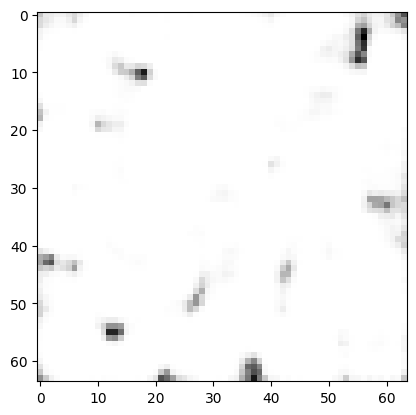

Epoch 21 : 


100%|██████████| 50/50 [00:04<00:00, 12.28it/s]


loss:  0.7195816040039062  l_d:  0.10450494289398193  l_e:  0.10450494289398193  l_g:  0.1276429295539856
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


loss:  0.8806694746017456  l_d:  0.12551289796829224  l_e:  0.12551289796829224  l_g:  0.15741091966629028
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 14.85it/s]


loss:  0.8286082744598389  l_d:  0.10494749248027802  l_e:  0.10494749248027802  l_g:  0.1546783149242401
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


loss:  0.9232261776924133  l_d:  0.08539596945047379  l_e:  0.08539596199989319  l_g:  0.18810856342315674
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


loss:  1.0275821685791016  l_d:  0.09004944562911987  l_e:  0.09004944562911987  l_g:  0.21187081933021545
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


loss:  0.7741591334342957  l_d:  0.10887511819601059  l_e:  0.10887511819601059  l_g:  0.13910222053527832
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 14.47it/s]


loss:  0.875031590461731  l_d:  0.08750246465206146  l_e:  0.08750246465206146  l_g:  0.1750066727399826
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


loss:  0.8928220868110657  l_d:  0.09778812527656555  l_e:  0.09778812527656555  l_g:  0.17431145906448364
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


loss:  0.8417699933052063  l_d:  0.14834299683570862  l_e:  0.14834299683570862  l_g:  0.13627099990844727
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 12.51it/s]


loss:  0.8921518325805664  l_d:  0.10186909139156342  l_e:  0.10186909139156342  l_g:  0.1721034049987793
Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 12.73it/s]


loss:  0.8866598606109619  l_d:  0.11801335960626602  l_e:  0.11801335960626602  l_g:  0.16265828907489777
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


loss:  0.8123190999031067  l_d:  0.14684024453163147  l_e:  0.14684022963047028  l_g:  0.12965965270996094
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


loss:  0.5584632158279419  l_d:  0.08252198994159698  l_e:  0.08252198994159698  l_g:  0.09835480153560638
Epoch 34 : 


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


loss:  0.7766430377960205  l_d:  0.15455928444862366  l_e:  0.15455928444862366  l_g:  0.1168811172246933
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 14.39it/s]


loss:  0.9556570649147034  l_d:  0.094882071018219  l_e:  0.094882071018219  l_g:  0.19147323071956635
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 13.73it/s]


loss:  1.0429378747940063  l_d:  0.26410359144210815  l_e:  0.26410359144210815  l_g:  0.1286826729774475
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


loss:  0.8229051232337952  l_d:  0.11571703106164932  l_e:  0.11571703106164932  l_g:  0.14786776900291443
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 14.63it/s]


loss:  1.1081273555755615  l_d:  0.09225895255804062  l_e:  0.09225895255804062  l_g:  0.23090235888957977
Epoch 39 : 


100%|██████████| 50/50 [00:04<00:00, 11.57it/s]


loss:  1.1027778387069702  l_d:  0.08948834985494614  l_e:  0.08948834240436554  l_g:  0.23095029592514038
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


loss:  0.8522429466247559  l_d:  0.10063529014587402  l_e:  0.10063529014587402  l_g:  0.16274309158325195


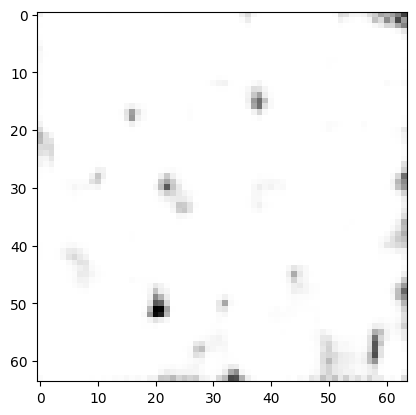

Epoch 41 : 


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


loss:  0.7043322920799255  l_d:  0.08513155579566956  l_e:  0.08513154834508896  l_g:  0.1335172951221466
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


loss:  1.0703729391098022  l_d:  0.08881857246160507  l_e:  0.08881857246160507  l_g:  0.22318395972251892
Epoch 43 : 


100%|██████████| 50/50 [00:04<00:00, 12.37it/s]


loss:  0.7075158357620239  l_d:  0.09052367508411407  l_e:  0.09052367508411407  l_g:  0.13161712884902954
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


loss:  0.7820682525634766  l_d:  0.0883263349533081  l_e:  0.0883263349533081  l_g:  0.1513538956642151
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 14.78it/s]


loss:  0.7071002721786499  l_d:  0.09500818699598312  l_e:  0.09500819444656372  l_g:  0.12927097082138062
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


loss:  0.7366488575935364  l_d:  0.10197863727807999  l_e:  0.10197863727807999  l_g:  0.1331728994846344
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


loss:  0.8214261531829834  l_d:  0.10612034797668457  l_e:  0.10612034797668457  l_g:  0.15229636430740356
Epoch 48 : 


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


loss:  0.9833630323410034  l_d:  0.08749234676361084  l_e:  0.08749234676361084  l_g:  0.20209458470344543
Epoch 49 : 


100%|██████████| 50/50 [00:03<00:00, 12.58it/s]


loss:  0.8734641075134277  l_d:  0.101712167263031  l_e:  0.101712167263031  l_g:  0.16750994324684143
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


loss:  0.9470549821853638  l_d:  0.08621350675821304  l_e:  0.08621350675821304  l_g:  0.19365699589252472
Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


loss:  0.8510831594467163  l_d:  0.11747317016124725  l_e:  0.11747317016124725  l_g:  0.15403419733047485
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


loss:  0.8009566068649292  l_d:  0.0869743674993515  l_e:  0.0869743674993515  l_g:  0.15675196051597595
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


loss:  0.9312818050384521  l_d:  0.088966965675354  l_e:  0.088966965675354  l_g:  0.18833696842193604
Epoch 54 : 


100%|██████████| 50/50 [00:04<00:00, 12.20it/s]


loss:  0.797430157661438  l_d:  0.08424173295497894  l_e:  0.08424173295497894  l_g:  0.15723668038845062
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 14.84it/s]


loss:  0.9450852274894714  l_d:  0.09487167000770569  l_e:  0.09487167000770569  l_g:  0.18883547186851501
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 13.06it/s]


loss:  0.9008232355117798  l_d:  0.08870749175548553  l_e:  0.08870749175548553  l_g:  0.18085205554962158
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


loss:  0.7724398970603943  l_d:  0.15783238410949707  l_e:  0.15783238410949707  l_g:  0.11419378221035004
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 12.63it/s]


loss:  0.6354681253433228  l_d:  0.08810719102621078  l_e:  0.08810718357563019  l_g:  0.114813432097435
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


loss:  0.8465979099273682  l_d:  0.08602380752563477  l_e:  0.08602380752563477  l_g:  0.16863757371902466
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


loss:  0.8356760740280151  l_d:  0.09240458160638809  l_e:  0.09240458160638809  l_g:  0.16271673142910004


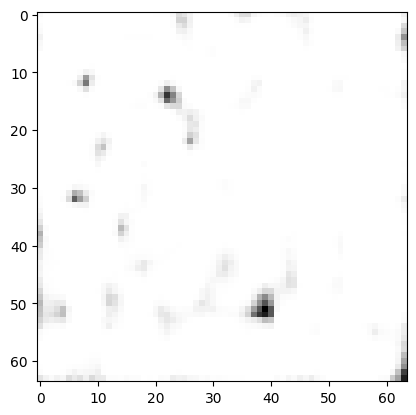

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


loss:  0.9297168254852295  l_d:  0.08757102489471436  l_e:  0.08757103979587555  l_g:  0.1886436939239502
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 12.83it/s]


loss:  1.0458735227584839  l_d:  0.1227811798453331  l_e:  0.1227811798453331  l_g:  0.20007778704166412
Epoch 63 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  0.8451576828956604  l_d:  0.08905037492513657  l_e:  0.08905037492513657  l_g:  0.16676422953605652
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


loss:  0.704628586769104  l_d:  0.09269867837429047  l_e:  0.09269867837429047  l_g:  0.12980781495571136
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


loss:  0.8732434511184692  l_d:  0.1657002717256546  l_e:  0.1657002717256546  l_g:  0.1354607343673706
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  0.7065221667289734  l_d:  0.08747652173042297  l_e:  0.08747652918100357  l_g:  0.13289228081703186
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


loss:  0.6545495390892029  l_d:  0.08941963315010071  l_e:  0.08941963315010071  l_g:  0.11892756819725037
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


loss:  0.7033299207687378  l_d:  0.09201328456401825  l_e:  0.09201328456401825  l_g:  0.12982583045959473
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


loss:  0.7682691216468811  l_d:  0.10029742866754532  l_e:  0.10029742866754532  l_g:  0.14191856980323792
Epoch 70 : 


100%|██████████| 50/50 [00:04<00:00, 12.35it/s]


loss:  0.8717546463012695  l_d:  0.08924496173858643  l_e:  0.08924496173858643  l_g:  0.17331618070602417
Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


loss:  0.8819525241851807  l_d:  0.0895172506570816  l_e:  0.0895172506570816  l_g:  0.17572951316833496
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


loss:  0.5962613224983215  l_d:  0.10507169365882874  l_e:  0.10507169365882874  l_g:  0.09652948379516602
Epoch 73 : 


100%|██████████| 50/50 [00:04<00:00, 11.73it/s]


loss:  0.7700134515762329  l_d:  0.08819122612476349  l_e:  0.08819122612476349  l_g:  0.14840775728225708
Epoch 74 : 


100%|██████████| 50/50 [00:04<00:00, 11.59it/s]


loss:  1.0377202033996582  l_d:  0.2481454312801361  l_e:  0.2481454461812973  l_g:  0.1353573203086853
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 12.79it/s]


loss:  0.7266910672187805  l_d:  0.08522940427064896  l_e:  0.08522939682006836  l_g:  0.13905806839466095
Epoch 76 : 


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


loss:  0.6807553768157959  l_d:  0.0866629108786583  l_e:  0.08666291832923889  l_g:  0.12685738503932953
Epoch 77 : 


100%|██████████| 50/50 [00:04<00:00, 11.95it/s]


loss:  0.7044645547866821  l_d:  0.08638836443424225  l_e:  0.08638836443424225  l_g:  0.13292196393013
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 13.94it/s]


loss:  1.047606110572815  l_d:  0.10393369197845459  l_e:  0.10393369197845459  l_g:  0.20993468165397644
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


loss:  0.8689280152320862  l_d:  0.0929088294506073  l_e:  0.0929088369011879  l_g:  0.1707775890827179
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  0.7476144433021545  l_d:  0.10489983856678009  l_e:  0.10489985346794128  l_g:  0.134453684091568


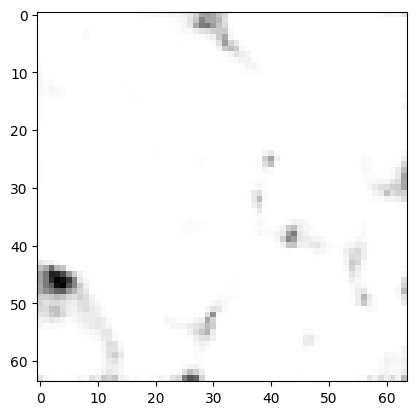

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


loss:  0.6847841739654541  l_d:  0.09040606766939163  l_e:  0.09040606766939163  l_g:  0.125993013381958
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  0.7690210342407227  l_d:  0.08969123661518097  l_e:  0.08969123661518097  l_g:  0.14740964770317078
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 13.57it/s]


loss:  0.7630302906036377  l_d:  0.08742354810237885  l_e:  0.08742354810237885  l_g:  0.1470457911491394
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 12.58it/s]


loss:  0.7587212920188904  l_d:  0.08461721986532211  l_e:  0.08461721986532211  l_g:  0.14737170934677124
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  0.7761561870574951  l_d:  0.09449554979801178  l_e:  0.09449554979801178  l_g:  0.1467912793159485
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


loss:  1.2671736478805542  l_d:  0.24396184086799622  l_e:  0.24396184086799622  l_g:  0.19481249153614044
Epoch 87 : 


100%|██████████| 50/50 [00:04<00:00, 11.85it/s]


loss:  0.919584333896637  l_d:  0.08539780974388123  l_e:  0.08539780974388123  l_g:  0.18719717860221863
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


loss:  0.9328027367591858  l_d:  0.08224579691886902  l_e:  0.08224579691886902  l_g:  0.19207778573036194
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


loss:  0.5386338233947754  l_d:  0.08482059091329575  l_e:  0.08482059091329575  l_g:  0.09224815666675568
Epoch 90 : 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


loss:  0.5770906209945679  l_d:  0.0859951376914978  l_e:  0.0859951376914978  l_g:  0.10127508640289307
Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


loss:  0.8613811731338501  l_d:  0.09096638858318329  l_e:  0.09096638858318329  l_g:  0.16986210644245148
Epoch 92 : 


100%|██████████| 50/50 [00:03<00:00, 12.66it/s]


loss:  0.9849068522453308  l_d:  0.08625569939613342  l_e:  0.08625569939613342  l_g:  0.203098863363266
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


loss:  0.7156813740730286  l_d:  0.08567652851343155  l_e:  0.08567652851343155  l_g:  0.13608208298683167
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  1.0827621221542358  l_d:  0.08431722223758698  l_e:  0.08431722223758698  l_g:  0.22853192687034607
Epoch 95 : 


100%|██████████| 50/50 [00:03<00:00, 14.26it/s]


loss:  0.5343568921089172  l_d:  0.08461052924394608  l_e:  0.08461052924394608  l_g:  0.09128396213054657
Epoch 96 : 


100%|██████████| 50/50 [00:03<00:00, 14.00it/s]


loss:  0.8993894457817078  l_d:  0.09272605925798416  l_e:  0.09272605925798416  l_g:  0.17848433554172516
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 12.55it/s]


loss:  0.9850813150405884  l_d:  0.18851420283317566  l_e:  0.18851418793201447  l_g:  0.15201322734355927
Epoch 98 : 


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


loss:  0.7566383481025696  l_d:  0.08292016386985779  l_e:  0.08292016386985779  l_g:  0.1476995050907135
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


loss:  0.9380022287368774  l_d:  0.08669413626194  l_e:  0.08669413626194  l_g:  0.19115349650382996
Epoch 100 : 


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


loss:  0.8449581861495972  l_d:  0.09665454924106598  l_e:  0.09665454924106598  l_g:  0.1629122644662857


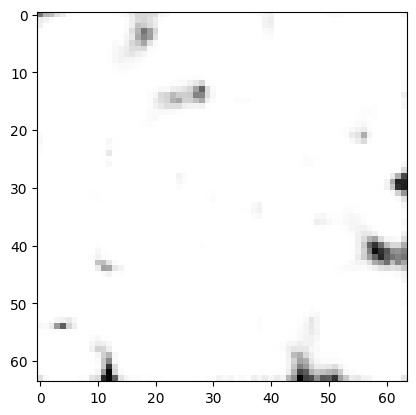

Epoch 101 : 


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


loss:  1.0472947359085083  l_d:  0.21576832234859467  l_e:  0.21576833724975586  l_g:  0.15393951535224915
Epoch 102 : 


100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


loss:  0.9457647800445557  l_d:  0.1831752210855484  l_e:  0.1831752210855484  l_g:  0.1448535919189453
Epoch 103 : 


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


loss:  0.6328431367874146  l_d:  0.1072559580206871  l_e:  0.1072559505701065  l_g:  0.10458280891180038
Epoch 104 : 


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


loss:  0.5543902516365051  l_d:  0.08691948652267456  l_e:  0.08691949397325516  l_g:  0.095137819647789
Epoch 105 : 


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


loss:  0.6776976585388184  l_d:  0.09834186732769012  l_e:  0.09834186732769012  l_g:  0.12025347352027893
Epoch 106 : 


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


loss:  0.9821949005126953  l_d:  0.24003827571868896  l_e:  0.24003827571868896  l_g:  0.12552958726882935
Epoch 107 : 


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


loss:  0.6737264394760132  l_d:  0.10786271840333939  l_e:  0.10786272585391998  l_g:  0.11450023949146271
Epoch 108 : 


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


loss:  0.6701626777648926  l_d:  0.11431513726711273  l_e:  0.11431513726711273  l_g:  0.11038309335708618
Epoch 109 : 


100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


loss:  1.0139610767364502  l_d:  0.1370222568511963  l_e:  0.13702227175235748  l_g:  0.1849791258573532
Epoch 110 : 


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


loss:  0.8931372165679932  l_d:  0.09555800259113312  l_e:  0.09555800259113312  l_g:  0.17550531029701233
Epoch 111 : 


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


loss:  0.7584336400032043  l_d:  0.08632281422615051  l_e:  0.08632281422615051  l_g:  0.14644700288772583
Epoch 112 : 


100%|██████████| 50/50 [00:03<00:00, 14.78it/s]


loss:  0.6468206644058228  l_d:  0.08341960608959198  l_e:  0.08341960608959198  l_g:  0.1199953705072403
Epoch 113 : 


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


loss:  0.9104963541030884  l_d:  0.08423912525177002  l_e:  0.08423912525177002  l_g:  0.18550452589988708
Epoch 114 : 


100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


loss:  0.993136465549469  l_d:  0.11600515246391296  l_e:  0.11600515246391296  l_g:  0.19028154015541077
Epoch 115 : 


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


loss:  0.9759911298751831  l_d:  0.10176511108875275  l_e:  0.10176511108875275  l_g:  0.193115234375
Epoch 116 : 


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


loss:  0.8368694186210632  l_d:  0.08741703629493713  l_e:  0.08741703629493713  l_g:  0.16550883650779724
Epoch 117 : 


100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


loss:  0.755409836769104  l_d:  0.09826136380434036  l_e:  0.09826136380434036  l_g:  0.13972178101539612
Epoch 118 : 


100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


loss:  0.7992466688156128  l_d:  0.09275203198194504  l_e:  0.09275203198194504  l_g:  0.15343564748764038
Epoch 119 : 


100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


loss:  0.6418389678001404  l_d:  0.08560103178024292  l_e:  0.08560103178024292  l_g:  0.11765922605991364
Epoch 120 : 


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


loss:  0.9081045389175415  l_d:  0.10823528468608856  l_e:  0.10823527723550797  l_g:  0.1729084998369217


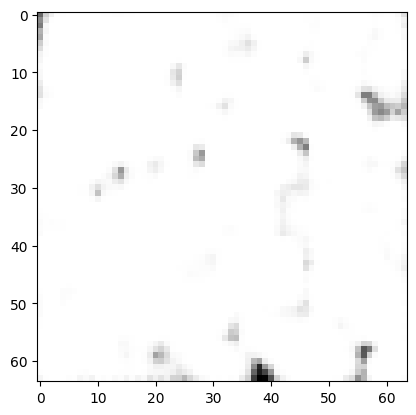

Epoch 121 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  0.9212452173233032  l_d:  0.08700515329837799  l_e:  0.08700515329837799  l_g:  0.1868087351322174
Epoch 122 : 


100%|██████████| 50/50 [00:03<00:00, 14.26it/s]


loss:  0.9440353512763977  l_d:  0.09140583127737045  l_e:  0.09140583872795105  l_g:  0.1903059184551239
Epoch 123 : 


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


loss:  0.835698127746582  l_d:  0.08484902232885361  l_e:  0.08484901487827301  l_g:  0.1665000170469284
Epoch 124 : 


100%|██████████| 50/50 [00:03<00:00, 14.82it/s]


loss:  0.8353233933448792  l_d:  0.08589735627174377  l_e:  0.08589734882116318  l_g:  0.1658821702003479
Epoch 125 : 


100%|██████████| 50/50 [00:04<00:00, 12.33it/s]


loss:  0.5405877232551575  l_d:  0.08725479245185852  l_e:  0.08725478500127792  l_g:  0.09151953458786011
Epoch 126 : 


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


loss:  0.7951064705848694  l_d:  0.08566225320100784  l_e:  0.08566225320100784  l_g:  0.15594549477100372
Epoch 127 : 


100%|██████████| 50/50 [00:03<00:00, 13.73it/s]


loss:  0.5414658784866333  l_d:  0.09206197410821915  l_e:  0.09206197410821915  l_g:  0.08933548629283905
Epoch 128 : 


100%|██████████| 50/50 [00:03<00:00, 12.55it/s]


loss:  0.6073198318481445  l_d:  0.08597932755947113  l_e:  0.08597932010889053  l_g:  0.10884028673171997
Epoch 129 : 


100%|██████████| 50/50 [00:04<00:00, 12.50it/s]


loss:  1.046843409538269  l_d:  0.2643249034881592  l_e:  0.2643249034881592  l_g:  0.12954840064048767
Epoch 130 : 


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


loss:  0.9834789037704468  l_d:  0.08883802592754364  l_e:  0.08883802592754364  l_g:  0.20145070552825928
Epoch 131 : 


100%|██████████| 50/50 [00:03<00:00, 14.80it/s]


loss:  0.7053103446960449  l_d:  0.08557222783565521  l_e:  0.08557222783565521  l_g:  0.13354146480560303
Epoch 132 : 


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


loss:  0.9733453392982483  l_d:  0.13533776998519897  l_e:  0.13533776998519897  l_g:  0.17566744983196259
Epoch 133 : 


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


loss:  0.808659553527832  l_d:  0.08700020611286163  l_e:  0.08700019866228104  l_g:  0.1586647927761078
Epoch 134 : 


100%|██████████| 50/50 [00:03<00:00, 16.42it/s]


loss:  0.7782880663871765  l_d:  0.08659431338310242  l_e:  0.08659431338310242  l_g:  0.15127485990524292
Epoch 135 : 


100%|██████████| 50/50 [00:02<00:00, 17.27it/s]


loss:  0.7569073438644409  l_d:  0.08904683589935303  l_e:  0.08904685080051422  l_g:  0.14470341801643372
Epoch 136 : 


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


loss:  0.6127468347549438  l_d:  0.08513620495796204  l_e:  0.08513620495796204  l_g:  0.11061860620975494
Epoch 137 : 


100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


loss:  1.0941537618637085  l_d:  0.11958760023117065  l_e:  0.11958760023117065  l_g:  0.2137446403503418
Epoch 138 : 


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


loss:  0.672697126865387  l_d:  0.08356615155935287  l_e:  0.08356615155935287  l_g:  0.12639120221138
Epoch 139 : 


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


loss:  0.7237755060195923  l_d:  0.09215788543224335  l_e:  0.09215788543224335  l_g:  0.1348649263381958
Epoch 140 : 


100%|██████████| 50/50 [00:02<00:00, 17.55it/s]


loss:  0.993415355682373  l_d:  0.08667455613613129  l_e:  0.08667455613613129  l_g:  0.20501655340194702


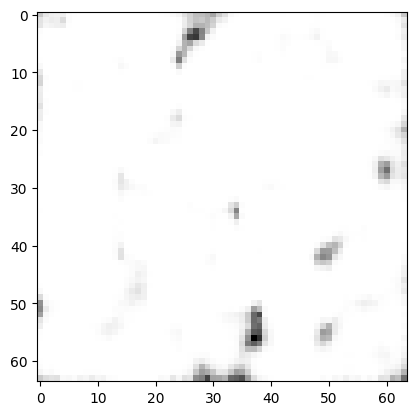

Epoch 141 : 


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


loss:  0.8908494114875793  l_d:  0.09685979038476944  l_e:  0.09685979038476944  l_g:  0.17428246140480042
Epoch 142 : 


100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


loss:  0.5760106444358826  l_d:  0.08502639085054398  l_e:  0.08502639085054398  l_g:  0.10148946940898895
Epoch 143 : 


100%|██████████| 50/50 [00:03<00:00, 16.22it/s]


loss:  0.652746856212616  l_d:  0.08405271172523499  l_e:  0.08405271172523499  l_g:  0.1211603581905365
Epoch 144 : 


100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


loss:  0.6996893882751465  l_d:  0.08785081654787064  l_e:  0.08785081654787064  l_g:  0.1309969425201416
Epoch 145 : 


100%|██████████| 50/50 [00:02<00:00, 17.17it/s]


loss:  0.7904175519943237  l_d:  0.0904260203242302  l_e:  0.0904260203242302  l_g:  0.15239137411117554
Epoch 146 : 


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


loss:  0.7208534479141235  l_d:  0.11658991873264313  l_e:  0.11658991873264313  l_g:  0.12191839516162872
Epoch 147 : 


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


loss:  0.8589608073234558  l_d:  0.09343769401311874  l_e:  0.09343769401311874  l_g:  0.16802135109901428
Epoch 148 : 


100%|██████████| 50/50 [00:03<00:00, 16.65it/s]


loss:  0.7355191707611084  l_d:  0.08679522573947906  l_e:  0.08679522573947906  l_g:  0.14048217236995697
Epoch 149 : 


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


loss:  0.7175591588020325  l_d:  0.1257828325033188  l_e:  0.12578284740447998  l_g:  0.11649836599826813
Epoch 150 : 


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


loss:  0.9645676016807556  l_d:  0.11328151822090149  l_e:  0.11328151822090149  l_g:  0.18450114130973816
Epoch 151 : 


100%|██████████| 50/50 [00:03<00:00, 16.42it/s]


loss:  1.1207562685012817  l_d:  0.08347443491220474  l_e:  0.08347443491220474  l_g:  0.23845185339450836
Epoch 152 : 


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


loss:  0.7148575186729431  l_d:  0.09170883893966675  l_e:  0.09170883893966675  l_g:  0.1328599601984024
Epoch 153 : 


100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


loss:  0.9768803715705872  l_d:  0.08739995956420898  l_e:  0.08739995956420898  l_g:  0.2005201131105423
Epoch 154 : 


100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


loss:  0.6530598402023315  l_d:  0.08783064037561417  l_e:  0.08783063292503357  l_g:  0.1193496510386467
Epoch 155 : 


100%|██████████| 50/50 [00:02<00:00, 17.21it/s]


loss:  0.9116476774215698  l_d:  0.0853710025548935  l_e:  0.0853710025548935  l_g:  0.1852264106273651
Epoch 156 : 


100%|██████████| 50/50 [00:03<00:00, 15.86it/s]


loss:  0.8044553399085999  l_d:  0.08649852871894836  l_e:  0.08649852871894836  l_g:  0.15786457061767578
Epoch 157 : 


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


loss:  0.6771605014801025  l_d:  0.08621625602245331  l_e:  0.08621625602245331  l_g:  0.12618200480937958
Epoch 158 : 


100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


loss:  0.9345093369483948  l_d:  0.14892812073230743  l_e:  0.14892813563346863  l_g:  0.15916326642036438
Epoch 159 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  0.8716851472854614  l_d:  0.09270800650119781  l_e:  0.09270800650119781  l_g:  0.17156729102134705
Epoch 160 : 


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


loss:  0.8790643215179443  l_d:  0.08405318856239319  l_e:  0.08405318856239319  l_g:  0.1777394860982895


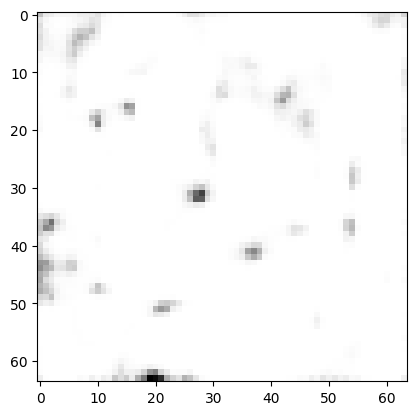

Epoch 161 : 


100%|██████████| 50/50 [00:02<00:00, 17.35it/s]


loss:  0.7613024711608887  l_d:  0.0847310870885849  l_e:  0.0847310870885849  l_g:  0.14796006679534912
Epoch 162 : 


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


loss:  0.8652676343917847  l_d:  0.08548421412706375  l_e:  0.08548421412706375  l_g:  0.1735748052597046
Epoch 163 : 


100%|██████████| 50/50 [00:03<00:00, 15.83it/s]


loss:  0.7648714780807495  l_d:  0.08576346933841705  l_e:  0.08576346933841705  l_g:  0.14833614230155945
Epoch 164 : 


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


loss:  1.136821985244751  l_d:  0.09054677188396454  l_e:  0.09054677188396454  l_g:  0.23893210291862488
Epoch 165 : 


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


loss:  0.9873822927474976  l_d:  0.09527076780796051  l_e:  0.09527076780796051  l_g:  0.19921019673347473
Epoch 166 : 


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


loss:  0.6571366786956787  l_d:  0.11151261627674103  l_e:  0.11151261627674103  l_g:  0.10852785408496857
Epoch 167 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  0.9633162617683411  l_d:  0.0910898819565773  l_e:  0.0910898819565773  l_g:  0.19528412818908691
Epoch 168 : 


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


loss:  0.6663307547569275  l_d:  0.0845198705792427  l_e:  0.0845198705792427  l_g:  0.12432275712490082
Epoch 169 : 


100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


loss:  0.8316228985786438  l_d:  0.08460310101509094  l_e:  0.08460310101509094  l_g:  0.16560417413711548
Epoch 170 : 


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


loss:  0.9903175830841064  l_d:  0.0914711207151413  l_e:  0.0914711132645607  l_g:  0.20184382796287537
Epoch 171 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  0.955903172492981  l_d:  0.09249789267778397  l_e:  0.09249789267778397  l_g:  0.19272685050964355
Epoch 172 : 


100%|██████████| 50/50 [00:03<00:00, 14.25it/s]


loss:  0.8633673191070557  l_d:  0.08874286711215973  l_e:  0.08874286711215973  l_g:  0.17147040367126465
Epoch 173 : 


100%|██████████| 50/50 [00:03<00:00, 14.14it/s]


loss:  1.061261773109436  l_d:  0.1056123599410057  l_e:  0.10561235249042511  l_g:  0.21250925958156586
Epoch 174 : 


100%|██████████| 50/50 [00:04<00:00, 11.79it/s]


loss:  0.473386287689209  l_d:  0.08617906272411346  l_e:  0.08617906272411346  l_g:  0.07525704056024551
Epoch 175 : 


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


loss:  0.7385626435279846  l_d:  0.09006506204605103  l_e:  0.09006506204605103  l_g:  0.13960812985897064
Epoch 176 : 


100%|██████████| 50/50 [00:03<00:00, 14.67it/s]


loss:  0.8516976833343506  l_d:  0.0855642706155777  l_e:  0.0855642706155777  l_g:  0.1701422780752182
Epoch 177 : 


100%|██████████| 50/50 [00:03<00:00, 12.61it/s]


loss:  0.975782036781311  l_d:  0.0846979171037674  l_e:  0.0846979171037674  l_g:  0.20159654319286346
Epoch 178 : 


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


loss:  0.8148722648620605  l_d:  0.08447478711605072  l_e:  0.08447477966547012  l_g:  0.16148066520690918
Epoch 179 : 


100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


loss:  0.8825057744979858  l_d:  0.08576823770999908  l_e:  0.08576823770999908  l_g:  0.17774233222007751
Epoch 180 : 


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


loss:  0.7571806907653809  l_d:  0.08715978264808655  l_e:  0.08715978264808655  l_g:  0.14571528136730194


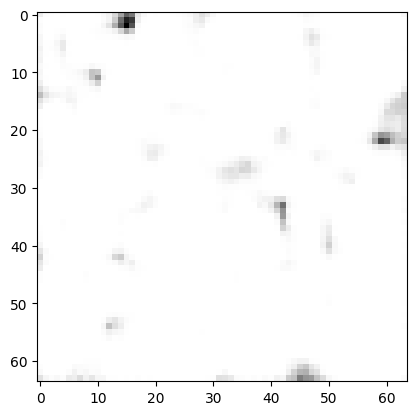

Epoch 181 : 


100%|██████████| 50/50 [00:04<00:00, 11.56it/s]


loss:  0.8229783773422241  l_d:  0.09672220051288605  l_e:  0.09672220051288605  l_g:  0.1573835015296936
Epoch 182 : 


100%|██████████| 50/50 [00:03<00:00, 14.85it/s]


loss:  0.7625874280929565  l_d:  0.08701382577419281  l_e:  0.08701382577419281  l_g:  0.14713995158672333
Epoch 183 : 


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


loss:  0.9217687249183655  l_d:  0.0958758294582367  l_e:  0.0958758294582367  l_g:  0.18250426650047302
Epoch 184 : 


100%|██████████| 50/50 [00:03<00:00, 15.39it/s]


loss:  0.7369944453239441  l_d:  0.0837324857711792  l_e:  0.0837324857711792  l_g:  0.14238236844539642
Epoch 185 : 


100%|██████████| 50/50 [00:03<00:00, 15.31it/s]


loss:  0.513725996017456  l_d:  0.08785241097211838  l_e:  0.08785240352153778  l_g:  0.08450530469417572
Epoch 186 : 


100%|██████████| 50/50 [00:03<00:00, 15.72it/s]


loss:  0.8062582015991211  l_d:  0.0888422429561615  l_e:  0.0888422429561615  l_g:  0.15714342892169952
Epoch 187 : 


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


loss:  0.8572078347206116  l_d:  0.08859536051750183  l_e:  0.08859536051750183  l_g:  0.17000427842140198
Epoch 188 : 


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


loss:  0.7318687438964844  l_d:  0.08604228496551514  l_e:  0.08604228496551514  l_g:  0.13994604349136353
Epoch 189 : 


100%|██████████| 50/50 [00:03<00:00, 16.16it/s]


loss:  0.8976337909698486  l_d:  0.08309401571750641  l_e:  0.08309401571750641  l_g:  0.18286144733428955
Epoch 190 : 


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


loss:  0.8612565994262695  l_d:  0.08546449989080429  l_e:  0.08546449989080429  l_g:  0.17258189618587494
Epoch 191 : 


100%|██████████| 50/50 [00:03<00:00, 15.39it/s]


loss:  0.6711941957473755  l_d:  0.08627428114414215  l_e:  0.08627428859472275  l_g:  0.1246614158153534
Epoch 192 : 


100%|██████████| 50/50 [00:03<00:00, 16.44it/s]


loss:  0.6712923645973206  l_d:  0.10444173216819763  l_e:  0.10444173216819763  l_g:  0.11560222506523132
Epoch 193 : 


100%|██████████| 50/50 [00:02<00:00, 17.63it/s]


loss:  1.0376169681549072  l_d:  0.09104037284851074  l_e:  0.09104037284851074  l_g:  0.21388407051563263
Epoch 194 : 


100%|██████████| 50/50 [00:03<00:00, 15.78it/s]


loss:  1.0338246822357178  l_d:  0.11085020005702972  l_e:  0.11085019260644913  l_g:  0.20303107798099518
Epoch 195 : 


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


loss:  0.8030120134353638  l_d:  0.09677042067050934  l_e:  0.09677042067050934  l_g:  0.15236780047416687
Epoch 196 : 


100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


loss:  0.9270390272140503  l_d:  0.08459477126598358  l_e:  0.08459477126598358  l_g:  0.18946237862110138
Epoch 197 : 


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


loss:  0.5512325763702393  l_d:  0.08503745496273041  l_e:  0.08503745496273041  l_g:  0.09528940916061401
Epoch 198 : 


100%|██████████| 50/50 [00:03<00:00, 15.84it/s]


loss:  0.6365580558776855  l_d:  0.08677899837493896  l_e:  0.08677900582551956  l_g:  0.1157500147819519
Epoch 199 : 


100%|██████████| 50/50 [00:03<00:00, 16.56it/s]


loss:  0.8059148192405701  l_d:  0.08582019805908203  l_e:  0.08582019805908203  l_g:  0.1585686057806015


In [32]:
train_d2c(200, 0.0005, 0.99, 0.00001, 4)

In [28]:
def interpolation(target1, target2):
    z1 = encoder(test_data[target1])
    z2 = encoder(test_data[target2])
    for i in range(11):
        z = (i/10)*z1+(10-i)/10*z2
        tensor_to_picture(decoder(z).detach().cpu().numpy()[0][0])
        

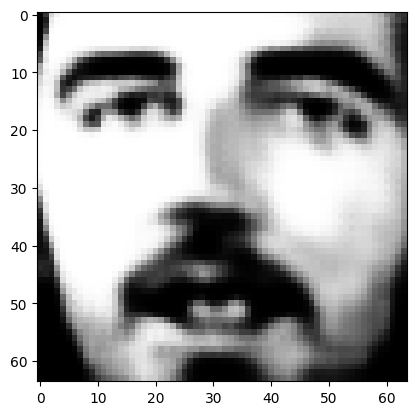

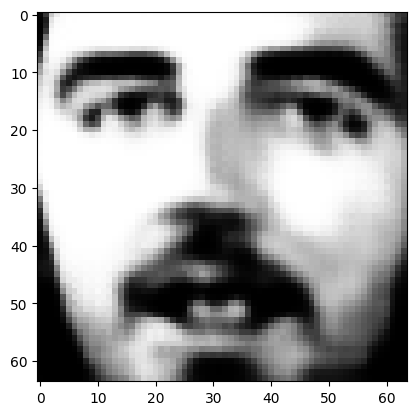

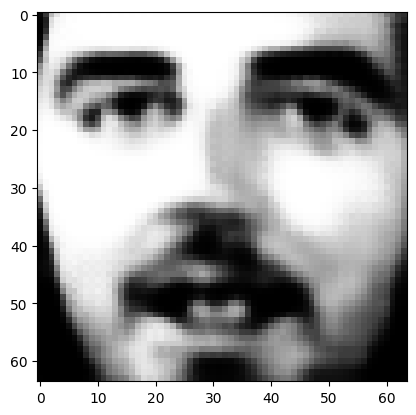

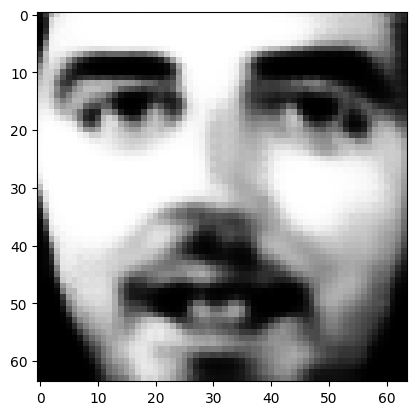

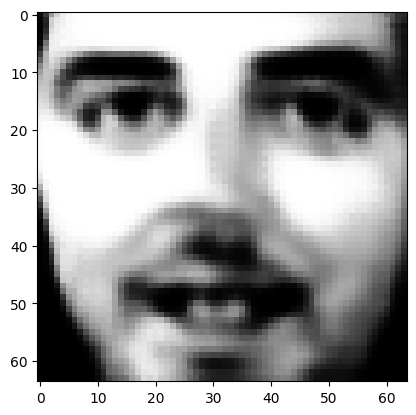

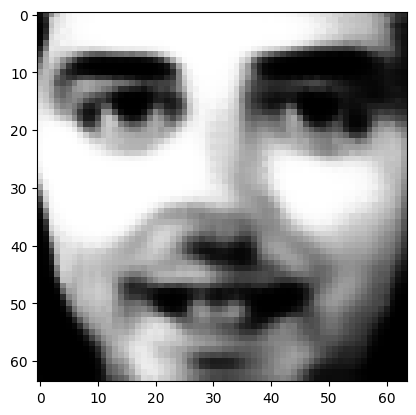

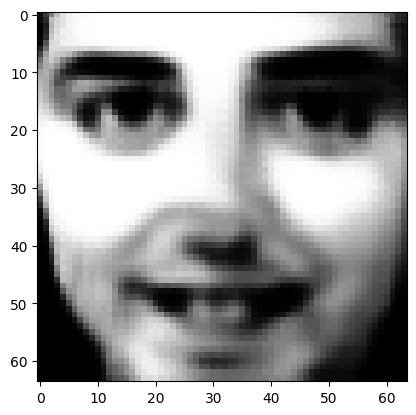

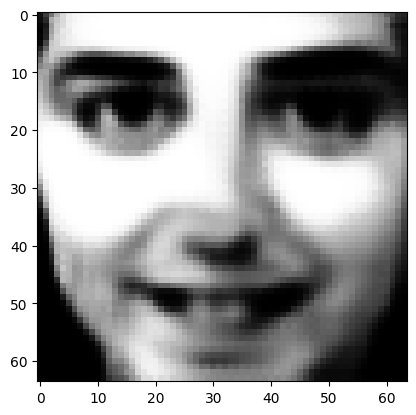

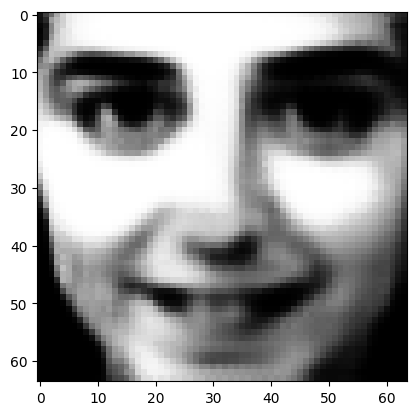

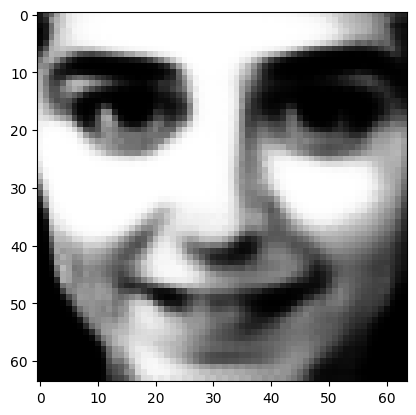

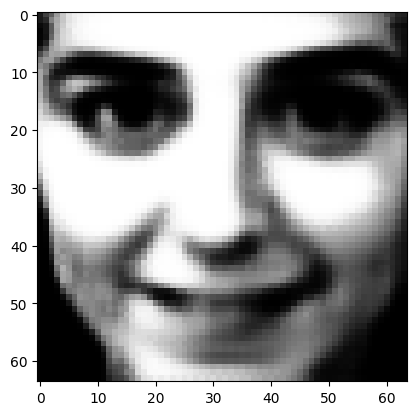

In [33]:
interpolation(90, 101)

In [34]:
cpu = torch.device('cpu')
ddpm.to(cpu)
encoder.to(cpu)
decoder.to(cpu)
torch.save(ddpm.state_dict(), f"./d2c_ddpm.pth")
torch.save(encoder.state_dict(), f"./d2c_encoder.pth")
torch.save(decoder.state_dict(), f"./d2c_decoder.pth")